Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from matplotlib.colors import LinearSegmentedColormap


Clean Dataset and convert all prices to USD

Exchange Rates: {'USD': 1, 'AED': 3.6725, 'AFN': 68.0798, 'ALL': 93.5864, 'AMD': 391.3829, 'ANG': 1.79, 'AOA': 921.3729, 'ARS': 1008.75, 'AUD': 1.5404, 'AWG': 1.79, 'AZN': 1.7002, 'BAM': 1.8533, 'BBD': 2.0, 'BDT': 119.4917, 'BGN': 1.8537, 'BHD': 0.376, 'BIF': 2943.2525, 'BMD': 1.0, 'BND': 1.3414, 'BOB': 6.9296, 'BRL': 5.8171, 'BSD': 1.0, 'BTN': 84.431, 'BWP': 13.6514, 'BYN': 3.3214, 'BZD': 2.0, 'CAD': 1.4036, 'CDF': 2849.8328, 'CHF': 0.882, 'CLP': 977.2072, 'CNY': 7.249, 'COP': 4398.7657, 'CRC': 510.4773, 'CUP': 24.0, 'CVE': 104.4858, 'CZK': 23.9394, 'DJF': 177.721, 'DKK': 7.0647, 'DOP': 60.2856, 'DZD': 133.7623, 'EGP': 49.6547, 'ERN': 15.0, 'ETB': 126.3864, 'EUR': 0.9476, 'FJD': 2.2713, 'FKP': 0.79, 'FOK': 7.0676, 'GBP': 0.7901, 'GEL': 2.7395, 'GGP': 0.79, 'GHS': 15.5142, 'GIP': 0.79, 'GMD': 71.879, 'GNF': 8596.5691, 'GTQ': 7.7127, 'GYD': 209.2331, 'HKD': 7.7815, 'HNL': 25.2876, 'HRK': 7.1396, 'HTG': 131.281, 'HUF': 390.7436, 'IDR': 15909.5283, 'ILS': 3.6547, 'IMP': 0.79, 'INR': 84.44

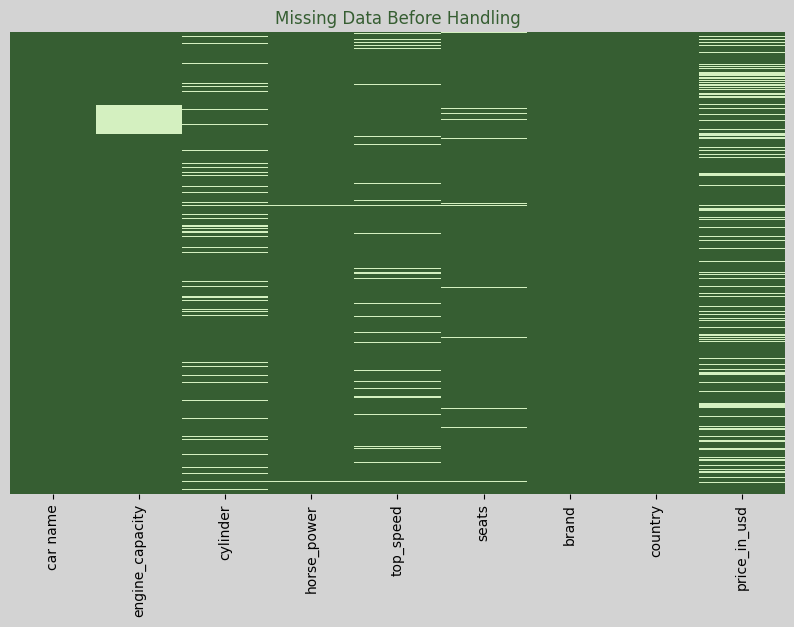

In [3]:
#read the Dataset
df = pd.read_csv("cars.csv")

#Cleaning Data
LIMIT_ENGINE_CAPACITY = 8.4
df['engine_capacity'] = pd.to_numeric(df['engine_capacity'], errors='coerce')
df['engine_capacity'] = np.where(df['engine_capacity'] <= LIMIT_ENGINE_CAPACITY, df['engine_capacity'], np.nan)

df['cylinder'] = pd.to_numeric(df['cylinder'], errors='coerce') 

df['horse_power'] = pd.to_numeric(df['horse_power'], errors='coerce')
df['horse_power'] = np.where(df['horse_power'] > 2000, np.nan, df['horse_power'])

df['top_speed'] = pd.to_numeric(df['top_speed'], errors='coerce')
invalid_entries = ['Automatic', '8 Seater', '4 Seater', '5 Seater', 'N A', 'CVT', 'Top Speed (Km/h)', '2 Seater', '7 Seater', '6 Seater', '3 Seater', '14 Seater', 'Top Speed (Km/h)', 'Seater']
df['top_speed'] = df['top_speed'].replace(invalid_entries, np.nan)
df['top_speed'] = np.where(df['top_speed'] > 550, np.nan, df['top_speed'])

df['seats'] = df['seats'].str.extract('(\d+)', expand=False) 
df['seats'] = pd.to_numeric(df['seats'], errors='coerce')
df['seats'] = np.where(df['seats'] > 15, np.nan, df['seats'])

api_url = "https://v6.exchangerate-api.com/v6/f2a14f4e64bbc4a0828a8c45/latest/USD"

#Get exchange rates from the API
response = requests.get(api_url)

if response.status_code == 200:
    exchange_data = response.json()  
    rates = exchange_data['conversion_rates']
    print("Exchange Rates:", rates)
else:
    print("Failed to fetch exchange rates. Status code:", response.status_code)
    # Initialize rates
    rates = {}  

#extract the currency code and price
def extract_currency_and_price(price):
    try:
        currency = price[:3]
        
        #extract the price string (everything after the first 3 characters)
        price_str = price[4:].replace(',', '')  
        price_value = float(price_str)
        
        return currency, price_value
    except (ValueError, IndexError) as e:
        return None, None

# applying the extraction function to price 
df[['currency', 'price']] = df['price'].apply(lambda x: pd.Series(extract_currency_and_price(x)))

#to convert all price to USD
def convert_to_usd(row, rates):
    currency = row['currency']
    price = row['price']
    if currency:
        conversion_rate = rates.get(currency, 1) 
        return price / conversion_rate
    else:
        return None  

df['price_in_usd'] = df.apply(lambda row: convert_to_usd(row, rates), axis=1)

#Drop the original price and currency columns
df.drop(columns=['price', 'currency'], inplace=True)
car_data = df[['car name', 'engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats', 'price_in_usd']]

#saving the data to a CSV file
car_data.to_csv('data_cleaning_colomns.csv', index=False)
print(df.dtypes)
print(df.head())

plt.figure(figsize=(10, 6), facecolor='lightgray')
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap=['#365E32', '#D4F0C0'])
plt.title('Missing Data Before Handling', color='#365E32')
plt.show()


1.  Dataset 

car name           0
engine_capacity    0
cylinder           0
horse_power        0
top_speed          0
seats              0
brand              0
country            0
price_in_usd       0
dtype: int64

After filling missing values:
car name           0
engine_capacity    0
cylinder           0
horse_power        0
top_speed          0
seats              0
brand              0
country            0
price_in_usd       0
dtype: int64


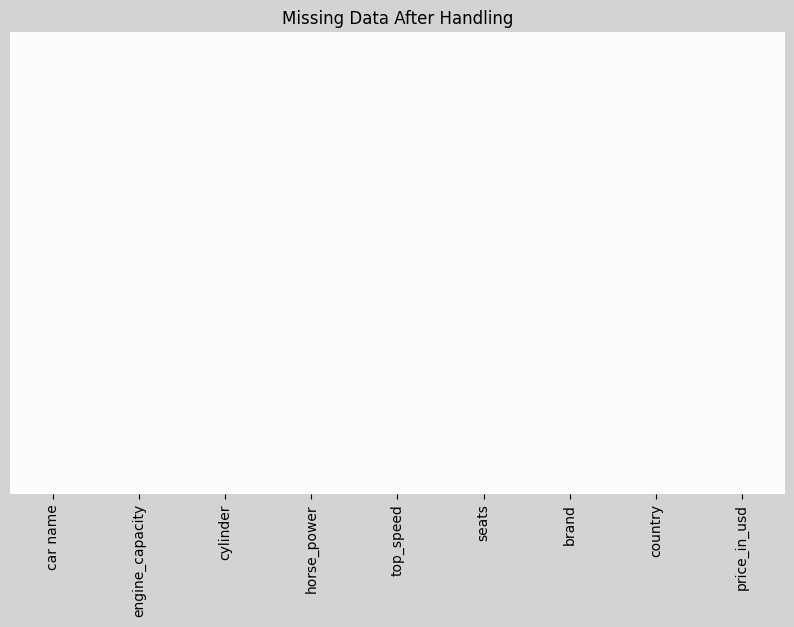

                           car name  engine_capacity  cylinder  horse_power  \
0           Fiat 500e 2021 La Prima              0.0       4.0        255.0   
1     Peugeot Traveller 2021 L3 VIP              2.0       4.0        180.0   
2  Suzuki Jimny 2021 1.5L Automatic              1.5       4.0        102.0   
3    Ford Bronco 2021 2.3T Big Bend              2.3       4.0        420.0   
4     Honda HR-V 2021 1.8 i-VTEC LX              1.8       4.0        140.0   

   top_speed  seats  brand  country  price_in_usd  
0      211.0    5.0     25        2  47106.875425  
1      211.0    8.0     62        2  37486.666667  
2      145.0    4.0     74        2  26342.666667  
3      211.0    7.0     26        2  52800.000000  
4      190.0    5.0     33        2  47106.875425  

Data Types of Columns:
car name            object
engine_capacity    float64
cylinder           float64
horse_power        float64
top_speed          float64
seats              float64
brand                int64


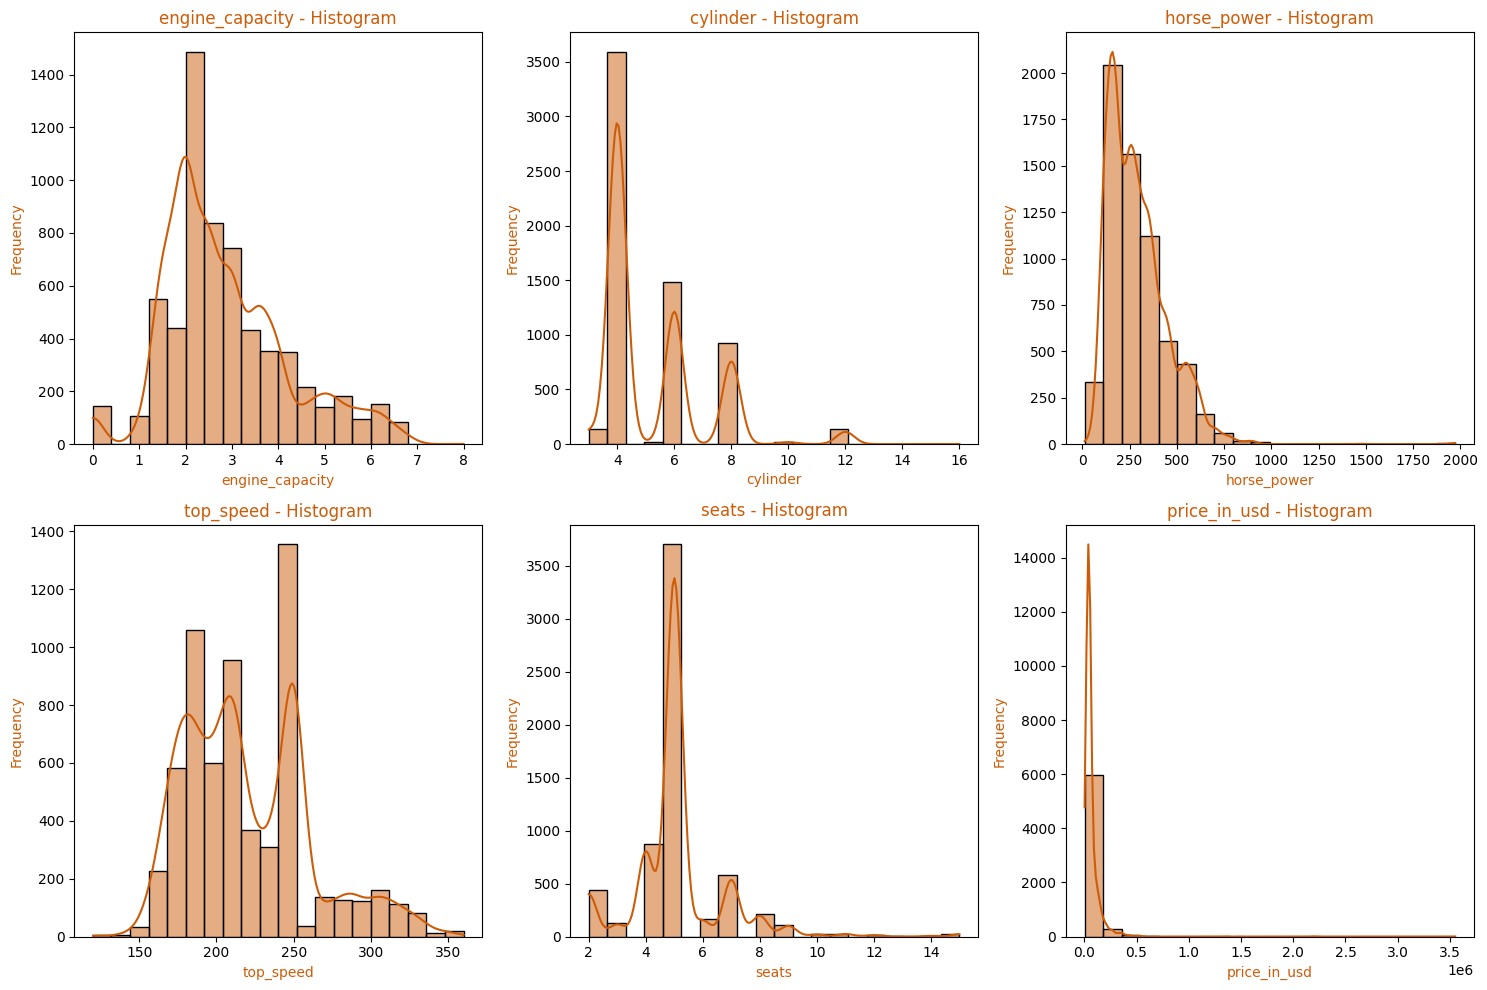

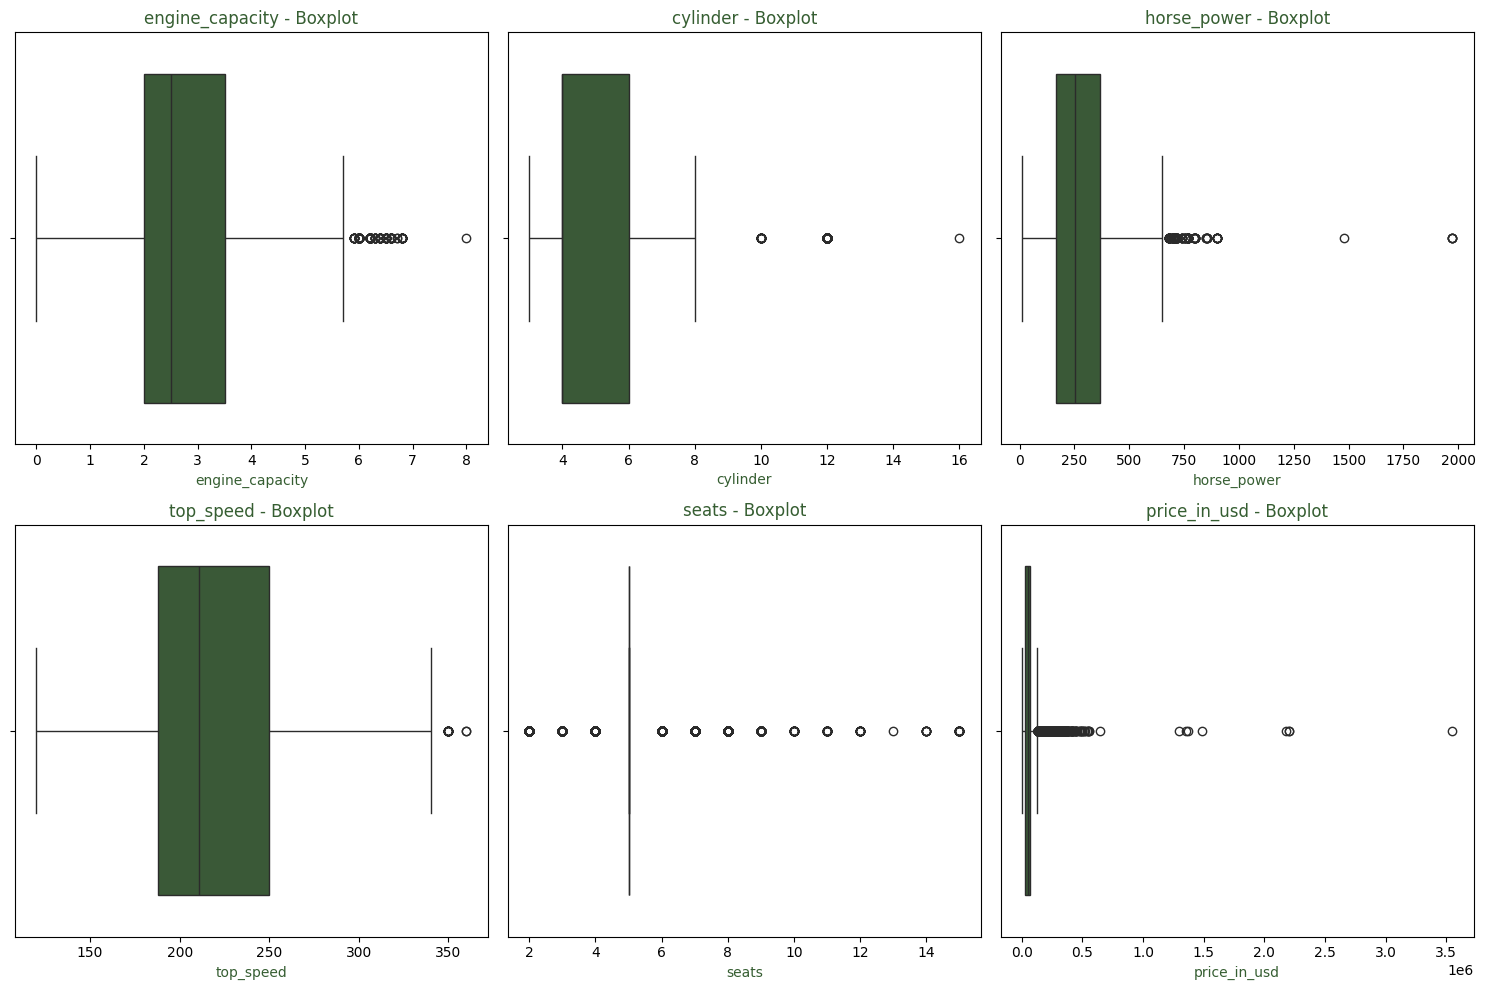

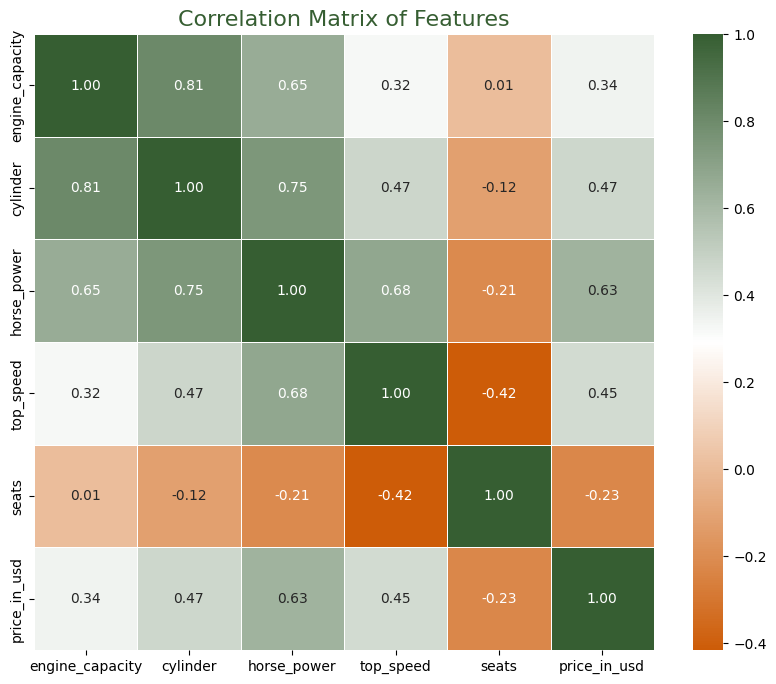

In [7]:
#Check missing values
print(df.isnull().sum())

#Fill missing values for numeric colomns with median
df['engine_capacity'] = df['engine_capacity'].fillna(df['engine_capacity'].median())
df['cylinder'] = df['cylinder'].fillna(df['cylinder'].median())
df['horse_power'] = df['horse_power'].fillna(df['horse_power'].median())
df['top_speed'] = df['top_speed'].fillna(df['top_speed'].median())
df['seats'] = df['seats'].fillna(df['seats'].median())
df['price_in_usd'] = df['price_in_usd'].fillna(df['price_in_usd'].median())

print("\nAfter filling missing values:")
print(df.isnull().sum())

#saving cleaned data with filling missing values in a csv file
car_data1 = df[['car name', 'engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats', 'price_in_usd']]
car_data1.to_csv('fill_missing_values.csv', index=False)

plt.figure(figsize=(10, 6), facecolor='lightgray')
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='Purples')
plt.title('Missing Data After Handling')
plt.show()

#    Applying Label Encoding to the categorical columns
label_encoder = LabelEncoder()
df['brand'] = label_encoder.fit_transform(df['brand'])
df['country'] = label_encoder.fit_transform(df['country'])

# Show the updated DataFrame and check data types
print(df.head())
print("\nData Types of Columns:")
print(df.dtypes)

# Separate features (X) and target (y) which is price
X = df.drop(columns=['price_in_usd', 'car name'])
y = df['price_in_usd']

# Standardize the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into training (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Scale the target variable (y)
target_scaler = StandardScaler()
y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val = target_scaler.transform(y_val.values.reshape(-1, 1)).flatten()
y_test = target_scaler.transform(y_test.values.reshape(-1, 1)).flatten()

# Save the datasets to CSV files for further use
train_df = pd.DataFrame(X_train, columns=X.columns) 
train_df['price_in_usd'] = y_train
train_df.to_csv('train_set.csv', index=False)

val_df = pd.DataFrame(X_val, columns=X.columns) 
val_df['price_in_usd'] = y_val 
val_df.to_csv('val_set.csv', index=False)

test_df = pd.DataFrame(X_test, columns=X.columns)
test_df['price_in_usd'] = y_test
test_df.to_csv('test_set.csv', index=False)

print("Data saved to train_set.csv, val_set.csv, and test_set.csv")

# Histogram and Boxplot for each feature
features = ['engine_capacity', 'cylinder', 'horse_power', 'top_speed', 'seats', 'price_in_usd']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, feature in enumerate(features):
    ax = axes[i // 3, i % 3]
    sns.histplot(df[feature], kde=True, ax=ax, color='#CD5C08', bins=20)
    ax.set_title(f'{feature} - Histogram', color='#CD5C08')
    ax.set_xlabel(feature, color='#CD5C08')
    ax.set_ylabel('Frequency', color='#CD5C08')
    
plt.tight_layout()
plt.show()

# Boxplot
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, feature in enumerate(features):
    ax = axes[i // 3, i % 3]
    sns.boxplot(x=df[feature], ax=ax, color='#365E32')
    ax.set_title(f'{feature} - Boxplot', color='#365E32')
    ax.set_xlabel(feature, color='#365E32')
    
plt.tight_layout()
plt.show()

# Correlation Matrix 
custom_cmap = LinearSegmentedColormap.from_list("OrangeGreen", ['#CD5C08', '#FFFFFF', '#365E32'])

correlation_matrix = df[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap=custom_cmap, fmt='.2f', cbar=True, linewidths=0.5)
plt.title('Correlation Matrix of Features', color='#365E32', fontsize=16)
plt.show()

2.  Building Regression Models

2.1. Linear Regression model (Scikit-learn Implementation)

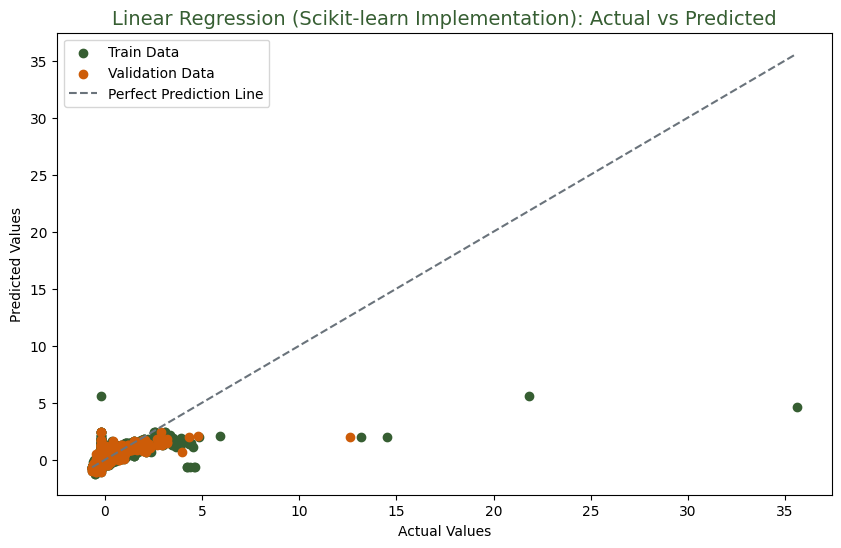

Training MSE (Linear Regression (Scikit-learn Implementation)): 0.6259127595056772
Validation MSE (Linear Regression (Scikit-learn Implementation)): 0.24047590338159236


In [8]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_train_pred = linear_model.predict(X_train)
y_val_pred = linear_model.predict(X_val)

#Plotting Actual vs Predicted for target
plt.figure(figsize=(10, 6))

#Scatter plot for training data
plt.scatter(y_train, y_train_pred, color='#365E32', label='Train Data')

#   Scatter plot for validation data
plt.scatter(y_val, y_val_pred, color='#CD5C08', label='Validation Data')

#Perfect prediction line
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         color='#6A737B', linestyle='--', label='Perfect Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Linear Regression (Scikit-learn Implementation): Actual vs Predicted', fontsize=14, color='#365E32')
plt.legend()

plt.show()

#evaluate the model on training and validation sets
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
print(f"Training MSE (Linear Regression (Scikit-learn Implementation)): {train_mse}")
print(f"Validation MSE (Linear Regression (Scikit-learn Implementation)): {val_mse}")

2.2. Linear Regression (Closed-form Solution)

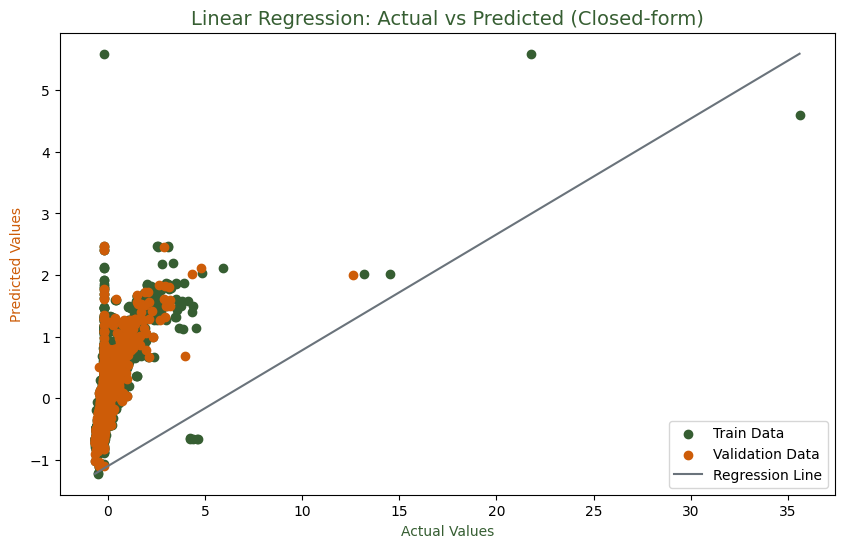

Training MSE (Closed-form Linear Regression): 0.6259127595056772
Validation MSE (Closed-form Linear Regression): 0.24047590338159228


In [9]:
def linear_regression_closed_form(X_train, y_train):
    X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]
    theta = np.linalg.inv(X_train_with_intercept.T @ X_train_with_intercept) @ X_train_with_intercept.T @ y_train
    return theta

# Predict with the model
def predict(X, theta):
    X_with_intercept = np.c_[np.ones(X.shape[0]), X]
    return X_with_intercept @ theta

#train the model and make predictions
theta = linear_regression_closed_form(X_train, y_train)
y_train_pred = predict(X_train, theta)
y_val_pred_cf = predict(X_val, theta)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 6))

#Scatter plot for training data
plt.scatter(y_train, y_train_pred, color='#365E32', label='Train Data')

# Scatter plot for validation data
plt.scatter(y_val, y_val_pred_cf, color='#CD5C08', label='Validation Data')

# Plot the regression line
plt.plot([min(y_train), max(y_train)], [min(y_train_pred), max(y_train_pred)], color='#6A737B', label='Regression Line')
plt.xlabel('Actual Values', color='#365E32')
plt.ylabel('Predicted Values', color='#CD5C08')
plt.title('Linear Regression: Actual vs Predicted (Closed-form)', fontsize=14, color='#365E32')
plt.legend()

plt.show()

# Evaluate the model on training and validation sets
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_val_pred_cf)
print(f"Training MSE (Closed-form Linear Regression): {train_mse}")
print(f"Validation MSE (Closed-form Linear Regression): {val_mse}")

2.3. Linear Regression (Gradient Descent)

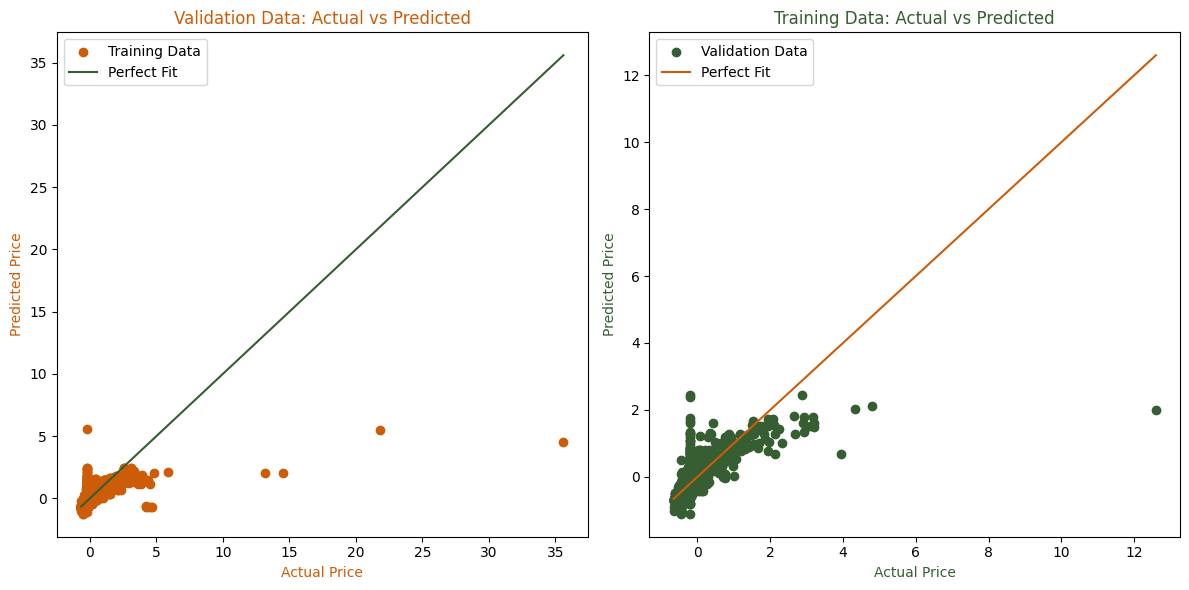

Training MSE (Gradient Descent Linear Regression): 0.6259246889085882
Validation MSE (Gradient Descent Linear Regression): 0.24017909869633508


In [11]:
def linear_regression_gradient_descent(X_train, y_train, learning_rate=0.01, epochs=1000):
    X_train_with_intercept = np.c_[np.ones(X_train.shape[0]), X_train]
    theta = np.zeros(X_train_with_intercept.shape[1])
    for epoch in range(epochs):
        gradients = -2 * X_train_with_intercept.T @ (y_train - X_train_with_intercept @ theta) / len(y_train)
        theta -= learning_rate * gradients
        
    return theta

# Train the model and make predictions
theta_gd = linear_regression_gradient_descent(X_train, y_train)
y_train_pred_gd = predict(X_train, theta_gd)
y_val_pred_gd = predict(X_val, theta_gd)

# plotting predictions vs actual values for training set
plt.figure(figsize=(12, 6))

# plot for Training data
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_gd, color='#CD5C08', label='Training Data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color='#365E32', label='Perfect Fit')
plt.title('Validation Data: Actual vs Predicted', color='#CD5C08')
plt.xlabel('Actual Price', color='#CD5C08')
plt.ylabel('Predicted Price', color='#CD5C08')
plt.legend()

# plotting for Validation data
plt.subplot(1, 2, 2)
plt.scatter(y_val, y_val_pred_gd, color='#365E32', label='Validation Data')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='#CD5C08', label='Perfect Fit')
plt.title('Training Data: Actual vs Predicted', color='#365E32')
plt.xlabel('Actual Price', color='#365E32')
plt.ylabel('Predicted Price', color='#365E32')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on training and validation sets
train_mse_gd = mean_squared_error(y_train, y_train_pred_gd)
val_mse_gd = mean_squared_error(y_val, y_val_pred_gd)
print(f"Training MSE (Gradient Descent Linear Regression): {train_mse_gd}")
print(f"Validation MSE (Gradient Descent Linear Regression): {val_mse_gd}")


2.4. LASSO (L1 Regularization), Ridge Regression (L2 Regularization)

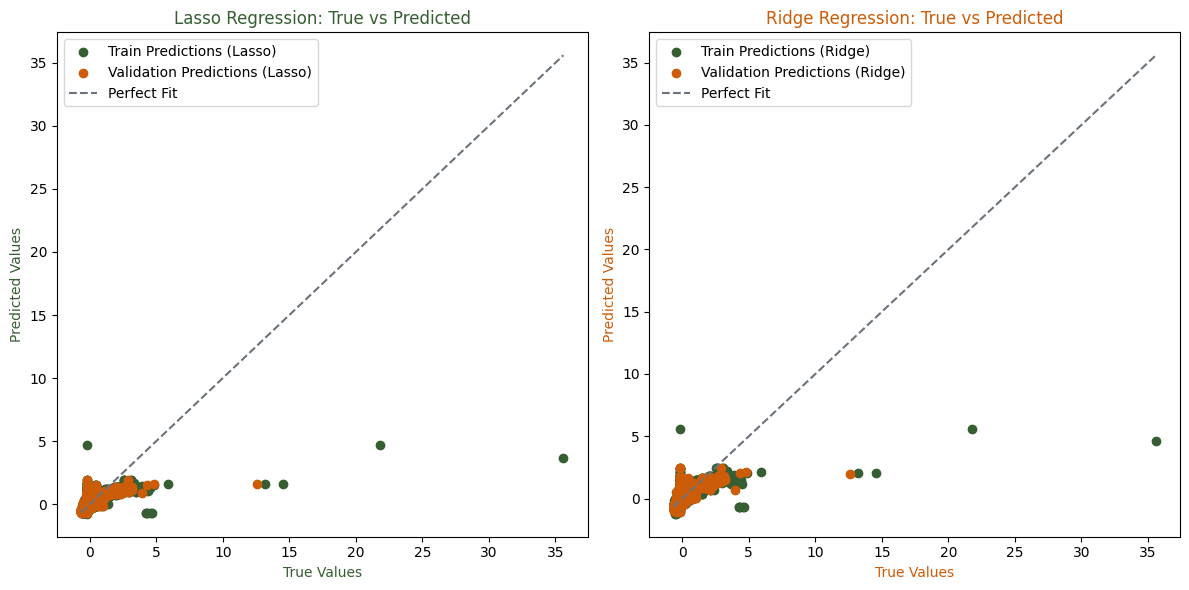

Training MSE (Lasso Regression): 0.6500717566630393
Validation MSE (Lasso Regression): 0.2436679710963041
Training MSE (Ridge Regression): 0.6259127601679395
Validation MSE (Ridge Regression): 0.24047324781234056


In [12]:
# Lasso Regression
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)
y_train_pred_lasso = lasso.predict(X_train)
y_val_pred_lasso = lasso.predict(X_val)

# Ridge Regression
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
y_train_pred_ridge = ridge.predict(X_train)
y_val_pred_ridge = ridge.predict(X_val)


# Plotting true vs predicted values
plt.figure(figsize=(12, 6))

# Lasso Regression Plot
plt.subplot(1, 2, 1)
plt.scatter(y_train, y_train_pred_lasso, color='#365E32', label='Train Predictions (Lasso)')  
plt.scatter(y_val, y_val_pred_lasso, color='#CD5C08', label='Validation Predictions (Lasso)')  
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='#6A737B', linestyle='--', label='Perfect Fit')  
plt.title("Lasso Regression: True vs Predicted", color='#365E32')
plt.xlabel("True Values", color='#365E32')
plt.ylabel("Predicted Values", color='#365E32')
plt.legend()

# Ridge Regression Plot
plt.subplot(1, 2, 2)
plt.scatter(y_train, y_train_pred_ridge, color='#365E32', label='Train Predictions (Ridge)')  
plt.scatter(y_val, y_val_pred_ridge, color='#CD5C08', label='Validation Predictions (Ridge)') 
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='#6A737B', linestyle='--', label='Perfect Fit')  
plt.title("Ridge Regression: True vs Predicted", color='#CD5C08')
plt.xlabel("True Values", color='#CD5C08')
plt.ylabel("Predicted Values", color='#CD5C08')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the models on training and validation sets
train_mse_lasso = mean_squared_error(y_train, y_train_pred_lasso)
val_mse_lasso = mean_squared_error(y_val, y_val_pred_lasso)
train_mse_ridge = mean_squared_error(y_train, y_train_pred_ridge)
val_mse_ridge = mean_squared_error(y_val, y_val_pred_ridge)
print(f"Training MSE (Lasso Regression): {train_mse_lasso}")
print(f"Validation MSE (Lasso Regression): {val_mse_lasso}")
print(f"Training MSE (Ridge Regression): {train_mse_ridge}")
print(f"Validation MSE (Ridge Regression): {val_mse_ridge}")


2.5. Nonlinear Model: RBF Kernel Regression (using Support Vector Regression)

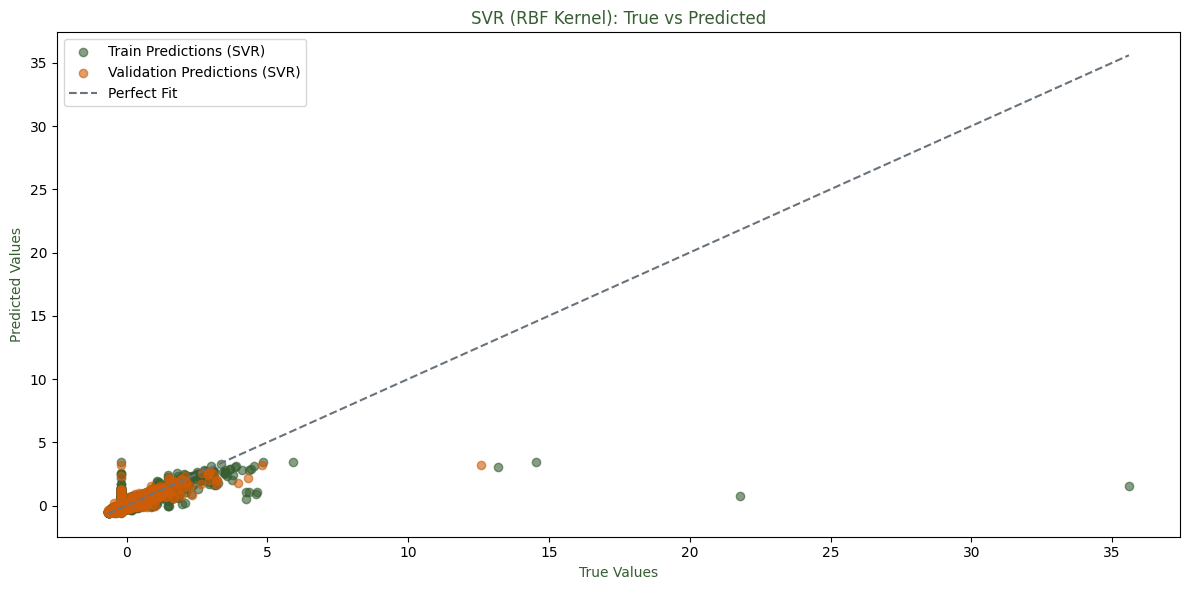

Training MSE (RBF Kernel Regression): 0.5877440138264541
Validation MSE (RBF Kernel Regression): 0.1551688783370208


In [13]:
svr = SVR(kernel='rbf', C=1, epsilon=0.1)
svr.fit(X_train, y_train)
y_train_pred_svr = svr.predict(X_train)
y_val_pred_svr = svr.predict(X_val)

# Plotting True vs Predicted
plt.figure(figsize=(12, 6))

# SVR Regression Plot
plt.scatter(y_train, y_train_pred_svr, color='#365E32', label='Train Predictions (SVR)', alpha=0.6) 
plt.scatter(y_val, y_val_pred_svr, color='#CD5C08', label='Validation Predictions (SVR)', alpha=0.6)  
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], color='#6A737B', linestyle='--', label='Perfect Fit') 
plt.title("SVR (RBF Kernel): True vs Predicted", color='#365E32')
plt.xlabel("True Values", color='#365E32')
plt.ylabel("Predicted Values", color='#365E32')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate the model on training and validation sets
train_mse_svr = mean_squared_error(y_train, y_train_pred_svr)
val_mse_svr = mean_squared_error(y_val, y_val_pred_svr)
print(f"Training MSE (RBF Kernel Regression): {train_mse_svr}")
print(f"Validation MSE (RBF Kernel Regression): {val_mse_svr}")


2.6. Nonlinear Models: Polynomial Regression (vary the polynomial degree from 2 to 10)

Degree 2 Polynomial Regression MSE: 0.20620970148544596
Degree 3 Polynomial Regression MSE: 0.15693098834062957
Degree 4 Polynomial Regression MSE: 0.20303770590043657
Degree 5 Polynomial Regression MSE: 4.820880632824037
Degree 6 Polynomial Regression MSE: 10022027.829055581
Degree 7 Polynomial Regression MSE: 25152453926.67241
Degree 8 Polynomial Regression MSE: 97479314898.4588
Degree 9 Polynomial Regression MSE: 13336615556.197817
Degree 10 Polynomial Regression MSE: 151951584034.8408


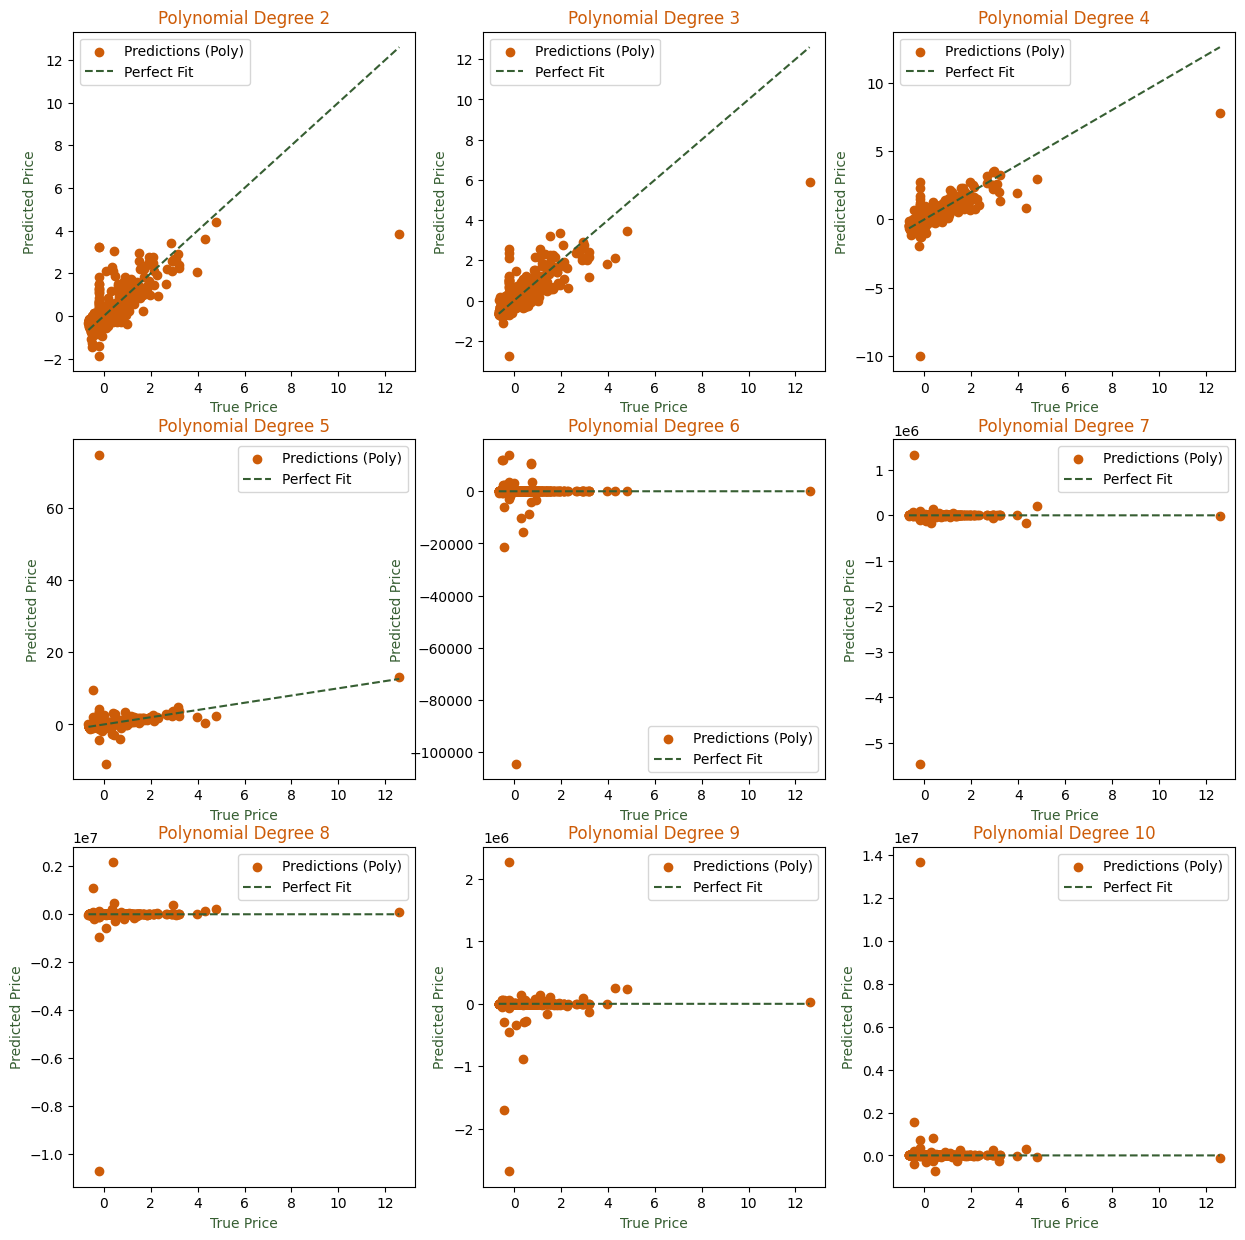

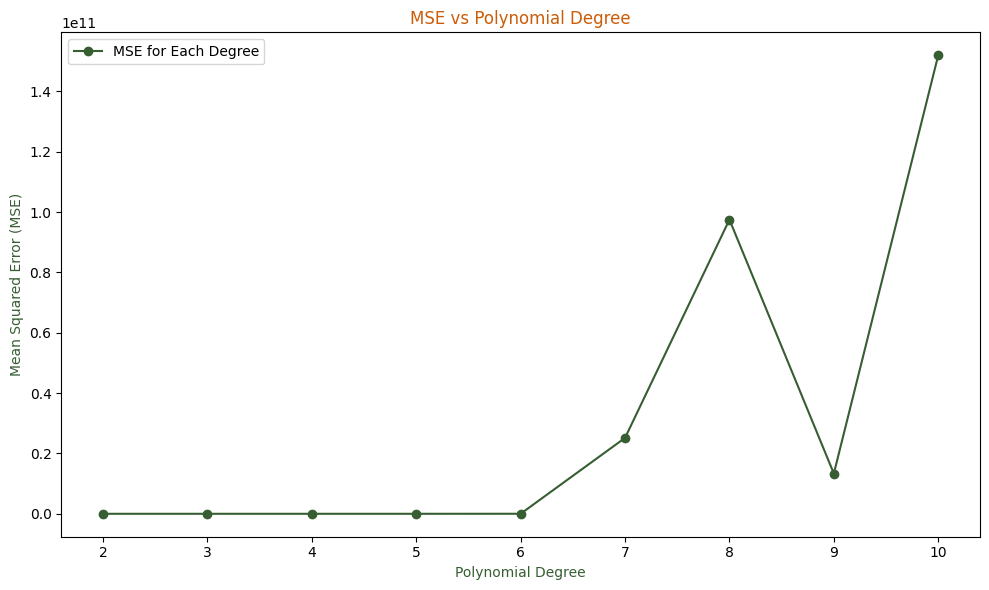

In [14]:
mse_values = []
predictions = {}

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for degree in range(2, 11):  # degrees from 2 to 10
    poly = PolynomialFeatures(degree=degree)
    X_poly_train = poly.fit_transform(X_train)
    X_poly_val = poly.transform(X_val)

    poly_regressor = LinearRegression()
    poly_regressor.fit(X_poly_train, y_train)

    y_pred = poly_regressor.predict(X_poly_val)
    predictions[degree] = y_pred 

    mse = mean_squared_error(y_val, y_pred)
    mse_values.append(mse)
    print(f"Degree {degree} Polynomial Regression MSE: {mse}")

    # Plot for each degree on individual subplots
    ax = axes[degree - 2]
    ax.scatter(y_val, y_pred, color='#CD5C08', label='Predictions (Poly)') 
    ax.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='#365E32', linestyle='--', label="Perfect Fit") 
    ax.set_xlabel('True Price', color='#365E32')
    ax.set_ylabel('Predicted Price', color='#365E32')
    ax.set_title(f'Polynomial Degree {degree}', color='#CD5C08')
    ax.legend()

# Plot MSE vs Polynomial Degree 
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(2, 11), mse_values, marker='o', linestyle='-', color='#365E32', label='MSE for Each Degree') 
ax.set_xlabel('Polynomial Degree', color='#365E32')
ax.set_ylabel('Mean Squared Error (MSE)', color='#365E32')
ax.set_title('MSE vs Polynomial Degree', color='#CD5C08')
ax.legend()

plt.tight_layout()
plt.show()


3. Model Selection Using Validation Set

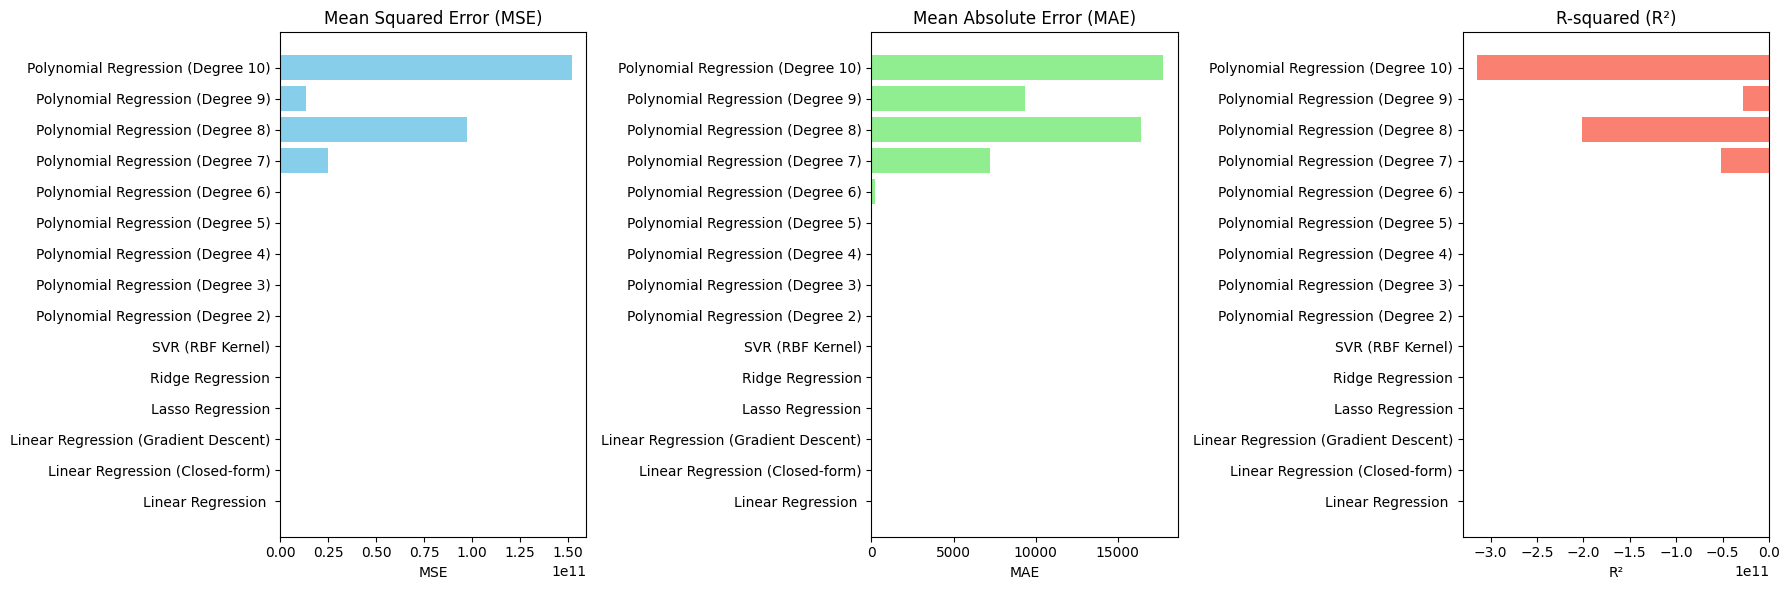

                                               MSE           MAE            R²
Linear Regression                     2.404759e-01      0.247218  5.027260e-01
Linear Regression (Closed-form)       2.404759e-01      0.247218  5.027260e-01
Linear Regression (Gradient Descent)  2.401791e-01      0.247001  5.033397e-01
Lasso Regression                      2.436680e-01      0.241881  4.961252e-01
Ridge Regression                      2.404732e-01      0.247215  5.027315e-01
SVR (RBF Kernel)                      1.551689e-01      0.172461  6.791302e-01
Polynomial Regression (Degree 2)      2.062097e-01      0.251278  5.735842e-01
Polynomial Regression (Degree 3)      1.569310e-01      0.216705  6.754864e-01
Polynomial Regression (Degree 4)      2.030377e-01      0.208461  5.801435e-01
Polynomial Regression (Degree 5)      4.820881e+00      0.286514 -8.968977e+00
Polynomial Regression (Degree 6)      1.002203e+07    214.103032 -2.072430e+07
Polynomial Regression (Degree 7)      2.515245e+10  

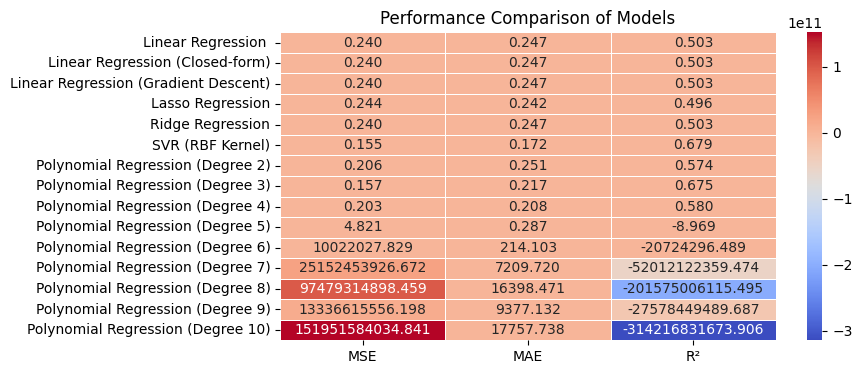


Best model by MSE: SVR (RBF Kernel) with MSE: 0.1551688783370208
Best model by R-squared: SVR (RBF Kernel) with R-squared: 0.6791302069320432


In [10]:
# Function to evaluate models with MSE, MAE and R-squared
def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return mse, mae, r2

metrics = {}

# Evaluate Linear Regression (Scikit-learn)
mse_lr, mae_lr, r2_lr = evaluate_model(y_val, y_val_pred, "Linear Regression)")
metrics["Linear Regression "] = (mse_lr, mae_lr, r2_lr)

# Evaluate Linear Regression (Closed-form)
mse_lr, mae_lr, r2_lr = evaluate_model(y_val, y_val_pred_cf, "Linear Regression (Closed-form)")
metrics["Linear Regression (Closed-form)"] = (mse_lr, mae_lr, r2_lr)

# Evaluate Linear Regression (Gradient Descent)
mse_lr_gd, mae_lr_gd, r2_lr_gd = evaluate_model(y_val, y_val_pred_gd, "Linear Regression (Gradient Descent)")
metrics["Linear Regression (Gradient Descent)"] = (mse_lr_gd, mae_lr_gd, r2_lr_gd)

# Evaluate Lasso Regression
mse_lasso, mae_lasso, r2_lasso = evaluate_model(y_val, y_val_pred_lasso, "Lasso Regression")
metrics["Lasso Regression"] = (mse_lasso, mae_lasso, r2_lasso)

# Evaluate Ridge Regression
mse_ridge, mae_ridge, r2_ridge = evaluate_model(y_val, y_val_pred_ridge, "Ridge Regression")
metrics["Ridge Regression"] = (mse_ridge, mae_ridge, r2_ridge)

# Evaluate SVR (RBF Kernel)
mse_svr, mae_svr, r2_svr = evaluate_model(y_val, y_val_pred_svr, "SVR (RBF Kernel)")
metrics["SVR (RBF Kernel)"] = (mse_svr, mae_svr, r2_svr)

# Evaluate Polynomial Regression
for degree, y_pred in predictions.items():
    mse_poly, mae_poly, r2_poly = evaluate_model(y_val, y_pred, f"Polynomial Regression (Degree {degree})")
    metrics[f"Polynomial Regression (Degree {degree})"] = (mse_poly, mae_poly, r2_poly)


# Bar Plot for Comparison of MSE, MAE, and R²
models = list(metrics.keys())
mse_values = [metrics[model][0] for model in models]
mae_values = [metrics[model][1] for model in models]
r2_values = [metrics[model][2] for model in models]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].barh(models, mse_values, color='skyblue')
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_xlabel('MSE')

axes[1].barh(models, mae_values, color='lightgreen')
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_xlabel('MAE')

axes[2].barh(models, r2_values, color='salmon')
axes[2].set_title('R-squared (R²)')
axes[2].set_xlabel('R²')

plt.tight_layout()
plt.show()

# Table Summarizing the Performance of Each Regression Model
performance_df = pd.DataFrame.from_dict(metrics, orient='index', columns=['MSE', 'MAE', 'R²'])
print(performance_df)
plt.figure(figsize=(8, 4))
sns.heatmap(performance_df, annot=True, cmap='coolwarm', fmt='.3f', cbar=True, linewidths=0.5)
plt.title('Performance Comparison of Models')
plt.show()


# compare all models
best_mse_model = min(metrics, key=lambda x: metrics[x][0])  # lowest MSE
best_r2_model = max(metrics, key=lambda x: metrics[x][2])  # highest R-squared

print(f"\nBest model by MSE: {best_mse_model} with MSE: {metrics[best_mse_model][0]}")
print(f"Best model by R-squared: {best_r2_model} with R-squared: {metrics[best_r2_model][2]}")


4. Feature Selection with Forward Selection

Adding feature 2 gives MSE: 0.2535538025836624
Adding feature 4 gives MSE: 0.24364004148617657
Adding feature 1 gives MSE: 0.24145752506396925
Adding feature 3 gives MSE: 0.2402933013921875
Adding feature 5 gives MSE: 0.23950183787485962
Best feature set: [2, 4, 1, 3, 5]
Selected feature names:
['horse_power', 'seats', 'cylinder', 'top_speed', 'brand']


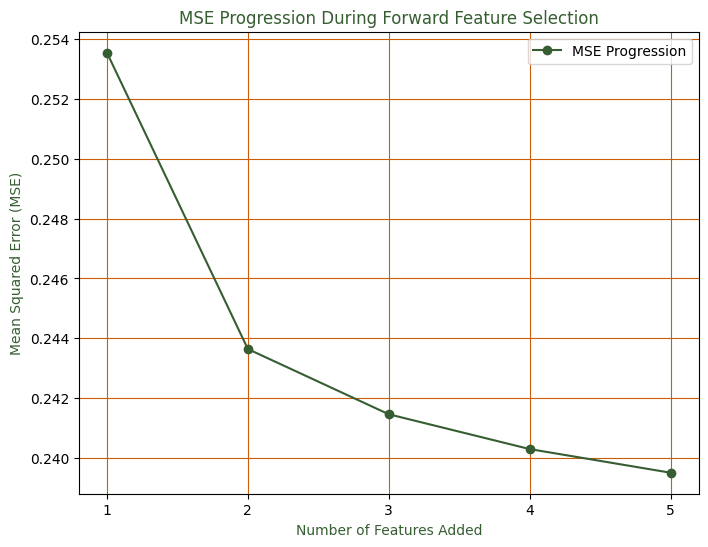

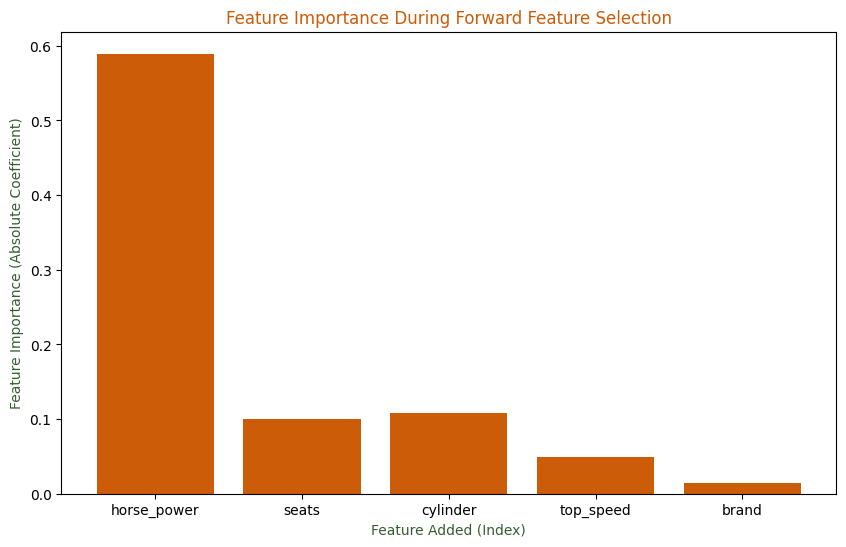

In [15]:
def forward_selection(X_train, y_train, X_val, y_val, max_features=None):
    selected_features = []
    remaining_features = list(range(X_train.shape[1]))
    mse_values = [] 
    feature_importances = [] 
    best_score = float('inf')
    
    while remaining_features:
        best_feature = None
        best_feature_score = float('inf')
        
        for feature in remaining_features:
            current_features = selected_features + [feature]
            
            model = LinearRegression()
            model.fit(X_train[:, current_features], y_train)
            
            y_val_pred = model.predict(X_val[:, current_features])
            mse = mean_squared_error(y_val, y_val_pred)
            
            # If model with this feature has a better performance, select it
            if mse < best_feature_score:
                best_feature_score = mse
                best_feature = feature
        
        # If adding the best feature improves the model, update selected features
        if best_feature is not None:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            mse_values.append(best_feature_score)
            
            model.fit(X_train[:, selected_features], y_train)
            feature_importances.append(np.abs(model.coef_[-1]))
            
            print(f"Adding feature {best_feature} gives MSE: {best_feature_score}")
        
        # Stop if the maximum number of features is reached
        if max_features and len(selected_features) >= max_features:
            break
    
    print(f"Best feature set: {selected_features}")
    return selected_features, mse_values, feature_importances

selected_features, mse_values, feature_importances = forward_selection(X_train, y_train, X_val, y_val, max_features=5)

# Map indices of selected features to column names
selected_feature_names = [X.columns[i] for i in selected_features]
print("Selected feature names:")
print(selected_feature_names)

# Plot the MSE values vs number of features added
features_added = list(range(1, len(mse_values) + 1))
plt.figure(figsize=(8, 6))
plt.plot(features_added, mse_values, marker='o', linestyle='-', color='#365E32', label='MSE Progression')  
plt.title('MSE Progression During Forward Feature Selection', color='#365E32')
plt.xlabel('Number of Features Added', color='#365E32')
plt.ylabel('Mean Squared Error (MSE)', color='#365E32')
plt.xticks(features_added)
plt.grid(True, color='#CD5C08') 
plt.legend()
plt.show()

# Plot the feature importances with feature names
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(feature_importances) + 1), feature_importances, color='#CD5C08') 
plt.title('Feature Importance During Forward Feature Selection', color='#CD5C08')
plt.xlabel('Feature Added (Index)', color='#365E32')
plt.ylabel('Feature Importance (Absolute Coefficient)', color='#365E32')
plt.xticks(range(1, len(feature_importances) + 1), selected_feature_names)
plt.show()

5. Applying Regularization Techniques

Best alpha for Lasso: 0.0001
Best alpha for Ridge: 890.2150854450392
MSE for Lasso: 0.23949518309528023
MSE for Ridge: 0.2367611475906773


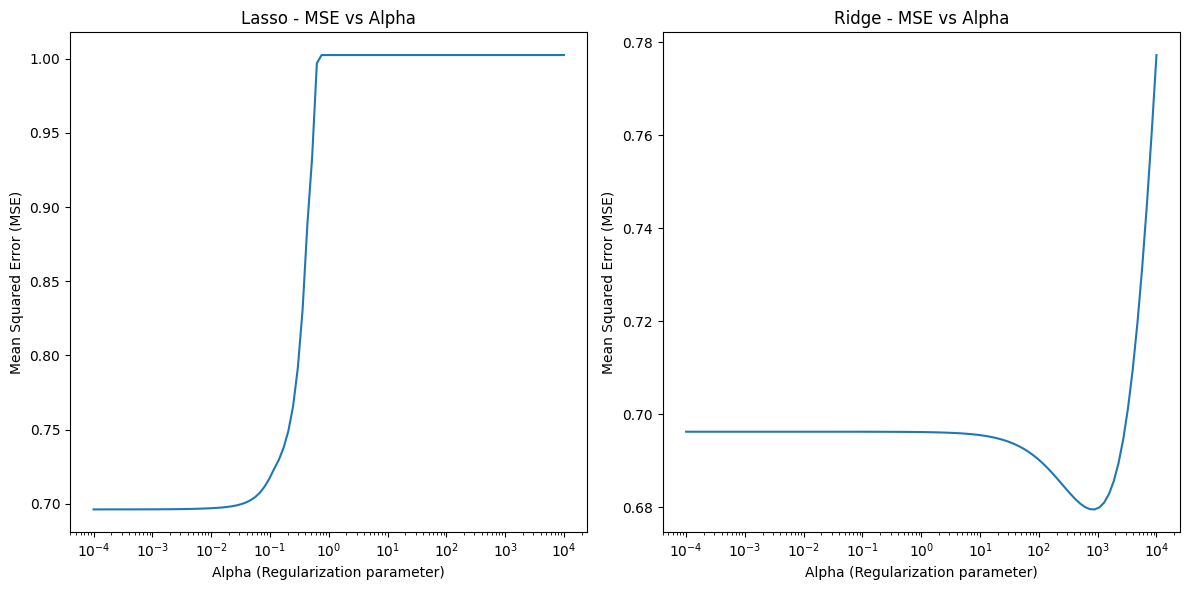

In [18]:
def regularization(X_train, y_train, X_val, y_val):
    alphas = np.logspace(-4, 4, 100)

    lasso = Lasso(max_iter=10000)
    ridge = Ridge(max_iter=10000)
    
    param_grid = {'alpha': alphas}
    
    # Apply Grid Search for Lasso
    grid_search_lasso = GridSearchCV(lasso, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search_lasso.fit(X_train, y_train)
    
    # Apply Grid Search for Ridge
    grid_search_ridge = GridSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search_ridge.fit(X_train, y_train)

    # Get the best alpha (lambda) for Lasso and Ridge
    best_alpha_lasso = grid_search_lasso.best_params_['alpha']
    best_alpha_ridge = grid_search_ridge.best_params_['alpha']
    
    print(f"Best alpha for Lasso: {best_alpha_lasso}")
    print(f"Best alpha for Ridge: {best_alpha_ridge}")
    
    # Train the best model for Lasso and Ridge
    best_lasso = grid_search_lasso.best_estimator_
    best_ridge = grid_search_ridge.best_estimator_

    # Make predictions and evaluate on validation set
    y_val_pred_lasso = best_lasso.predict(X_val)
    y_val_pred_ridge = best_ridge.predict(X_val)

    mse_lasso = mean_squared_error(y_val, y_val_pred_lasso)
    mse_ridge = mean_squared_error(y_val, y_val_pred_ridge)

    print(f"MSE for Lasso: {mse_lasso}")
    print(f"MSE for Ridge: {mse_ridge}")

    # Plotting MSE vs alpha for Lasso and Ridge
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.semilogx(alphas, -grid_search_lasso.cv_results_['mean_test_score'], label='Lasso')
    plt.title('Lasso - MSE vs Alpha')
    plt.xlabel('Alpha (Regularization parameter)')
    plt.ylabel('Mean Squared Error (MSE)')
    
    plt.subplot(1, 2, 2)
    plt.semilogx(alphas, -grid_search_ridge.cv_results_['mean_test_score'], label='Ridge')
    plt.title('Ridge - MSE vs Alpha')
    plt.xlabel('Alpha (Regularization parameter)')
    plt.ylabel('Mean Squared Error (MSE)')
    
    plt.tight_layout()
    plt.show()

    return best_lasso, best_ridge, mse_lasso, mse_ridge

X_train_selected = X_train[:, selected_features]  # Select the features from X_train
X_val_selected = X_val[:, selected_features]  # Select the features from X_val

# Perform regularization using the selected features
best_lasso, best_ridge, mse_lasso, mse_ridge = regularization(X_train_selected, y_train, X_val_selected, y_val)


6. Hyperparameter Tuning with Grid Search

Degree 2 - MSE for Polynomial Regression: 0.20722686656976286
Degree 3 - MSE for Polynomial Regression: 0.144690644131805
Degree 4 - MSE for Polynomial Regression: 0.10723919533079998
Degree 5 - MSE for Polynomial Regression: 0.1043949417726975
Degree 6 - MSE for Polynomial Regression: 3.5836848604023643
Degree 7 - MSE for Polynomial Regression: 372040.61125805514
Degree 8 - MSE for Polynomial Regression: 28045177718.854935
Degree 9 - MSE for Polynomial Regression: 180834505.62484455
Degree 10 - MSE for Polynomial Regression: 12024200587.848175
Best degree for Polynomial Regression: 5
Best MSE for Polynomial Regression: 0.1043949417726975
Best C for SVR: 10.0
Best epsilon for SVR: 0.1
MSE for SVR: 0.1373961255252276


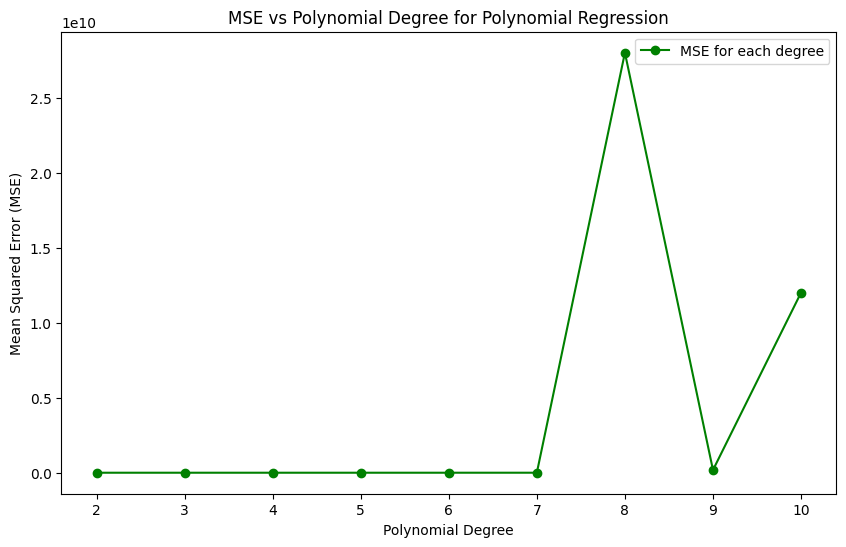

In [19]:
def tune_models(X_train, y_train, X_val, y_val):
    param_grid_svr = {
        'C': np.logspace(-2, 2, 5), 
        'epsilon': [0.01, 0.1, 0.5]
    }

    best_degree = None
    best_mse_poly = float('inf')
    best_svr_model = None
    best_mse_svr = float('inf')
    best_C = None
    best_epsilon = None

    mse_poly_values = []

    # Iterate over polynomial degrees from 2 to 10
    for degree in range(2, 11):
        poly = PolynomialFeatures(degree=degree)
        X_poly_train = poly.fit_transform(X_train)
        X_poly_val = poly.transform(X_val)
        
        poly_regressor = LinearRegression()
        poly_regressor.fit(X_poly_train, y_train)
        
        y_val_pred_poly = poly_regressor.predict(X_poly_val)
        mse_poly = mean_squared_error(y_val, y_val_pred_poly)
        print(f"Degree {degree} - MSE for Polynomial Regression: {mse_poly}")

        mse_poly_values.append(mse_poly)

        if mse_poly < best_mse_poly:
            best_mse_poly = mse_poly
            best_degree = degree

    print(f"Best degree for Polynomial Regression: {best_degree}")
    print(f"Best MSE for Polynomial Regression: {best_mse_poly}")
    
    # SVR Hyperparameter Tuning
    svr = SVR(kernel='rbf')
    grid_search_svr = GridSearchCV(svr, param_grid_svr, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search_svr.fit(X_train, y_train)
    
    best_params_svr = grid_search_svr.best_params_
    best_C = best_params_svr['C']
    best_epsilon = best_params_svr['epsilon']
    
    print(f"Best C for SVR: {best_C}")
    print(f"Best epsilon for SVR: {best_epsilon}")
    
    # Train the model with the best parameters
    best_svr = grid_search_svr.best_estimator_
    
    # Predict on validation set and calculate MSE
    y_val_pred_svr = best_svr.predict(X_val)
    mse_svr = mean_squared_error(y_val, y_val_pred_svr)
    
    print(f"MSE for SVR: {mse_svr}")

    return best_degree, best_mse_poly, best_svr, mse_svr, mse_poly_values, best_C

best_degree, best_mse_poly, best_svr_model, mse_svr, mse_poly_values, best_C = tune_models(X_train_selected, y_train, X_val_selected, y_val)

# Plot MSE vs Degree (for Polynomial Regression)
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), mse_poly_values, marker='o', linestyle='-', color='green', label='MSE for each degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE vs Polynomial Degree for Polynomial Regression')
plt.legend()
plt.show()


Find best model after enhance the models

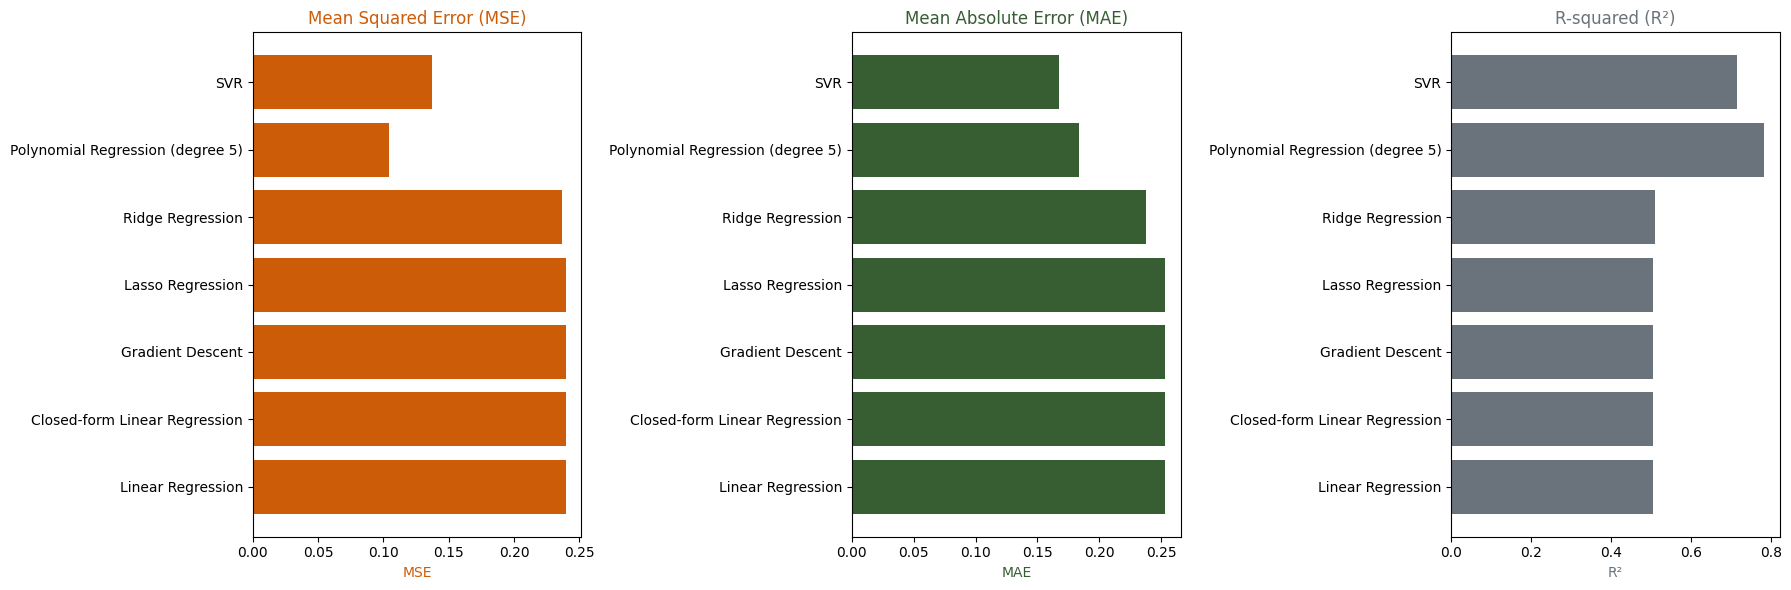

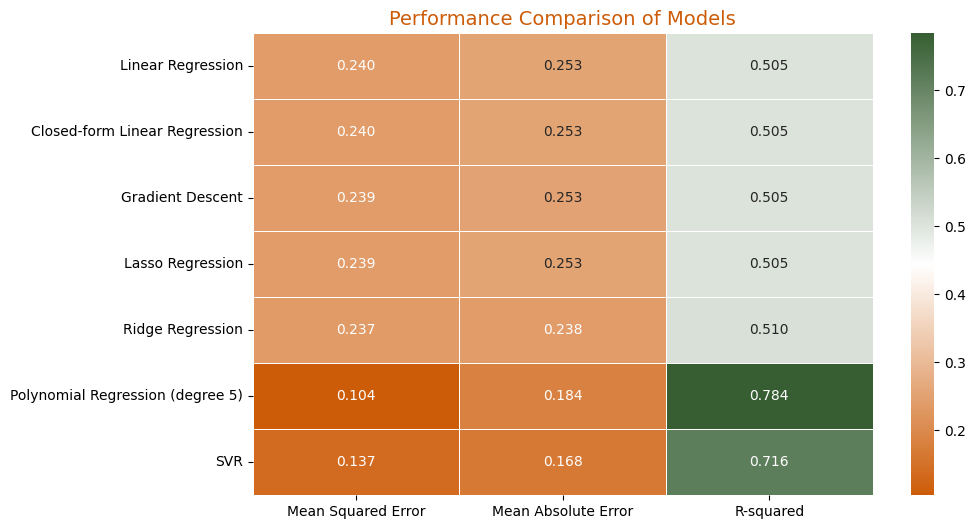


Best Model: Polynomial Regression (degree 5) - MSE: 0.104, MAE: 0.184, R²: 0.784


In [20]:
# Evaluate model function remains unchanged
def evaluate_model(model_name, y_true, y_pred):
    residuals = y_true - y_pred  # Calculate residuals
    metrics = {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "Residuals": residuals
    }
    return metrics


# Dictionary to store model metrics
model_metrics = {}

# Linear Regression (Scikit-learn)
model = LinearRegression().fit(X_train_selected, y_train)
model_metrics["Linear Regression"] = evaluate_model(
    "Linear Regression", y_val, model.predict(X_val_selected))

# Closed-form Linear Regression (Normal Equation)
X_train_bias = np.c_[np.ones(X_train_selected.shape[0]), X_train_selected]
X_val_bias = np.c_[np.ones(X_val_selected.shape[0]), X_val_selected]
theta = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train
model_metrics["Closed-form Linear Regression"] = evaluate_model(
    "Closed-form Linear Regression", y_val, X_val_bias @ theta)

# Gradient Descent Linear Regression
def predict(X, theta):
    X_with_bias = np.c_[np.ones(X.shape[0]), X]
    return X_with_bias @ theta


theta_gd = linear_regression_gradient_descent(X_train_selected, y_train)
y_val_pred_gd = predict(X_val_selected, theta_gd)
model_metrics["Gradient Descent"] = evaluate_model(
    "Gradient Descent", y_val, y_val_pred_gd)

# Lasso and Ridge Regression
for model_name, model in {"Lasso": best_lasso, "Ridge": best_ridge}.items():
    model_metrics[f"{model_name} Regression"] = evaluate_model(
        f"{model_name} Regression", y_val, model.predict(X_val_selected))

# Polynomial Regression
best_degree = 5 
poly = PolynomialFeatures(degree=best_degree)
X_train_poly, X_val_poly = poly.fit_transform(X_train_selected), poly.transform(X_val_selected)
poly_model = LinearRegression().fit(X_train_poly, y_train)
model_metrics[f"Polynomial Regression (degree {best_degree})"] = evaluate_model(
    f"Polynomial Regression (degree {best_degree})", y_val, poly_model.predict(X_val_poly))

# Support Vector Regression (SVR)
model_metrics["SVR"] = evaluate_model("SVR", y_val, best_svr_model.predict(X_val_selected))


# Performance Comparison Visualization
models = list(model_metrics.keys())
mse_values = [model_metrics[model]["MSE"] for model in models]
mae_values = [model_metrics[model]["MAE"] for model in models]
r2_values = [model_metrics[model]["R2"] for model in models]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].barh(models, mse_values, color='#CD5C08') 
axes[0].set_title('Mean Squared Error (MSE)', color='#CD5C08')
axes[0].set_xlabel('MSE', color='#CD5C08')

axes[1].barh(models, mae_values, color='#365E32')  
axes[1].set_title('Mean Absolute Error (MAE)', color='#365E32')
axes[1].set_xlabel('MAE', color='#365E32')

axes[2].barh(models, r2_values, color='#6A737B') 
axes[2].set_title('R-squared (R²)', color='#6A737B')
axes[2].set_xlabel('R²', color='#6A737B')

plt.tight_layout()
plt.show()

# Heatmap of Metrics
orange_green_cmap = LinearSegmentedColormap.from_list("OrangeGreen", ['#CD5C08', '#FFFFFF', '#365E32'])
performance_df = pd.DataFrame.from_dict(model_metrics, orient='index').drop(
    columns=["Residuals"], errors='ignore')
performance_df.rename(
    columns={"MSE": "Mean Squared Error", "MAE": "Mean Absolute Error", "R2": "R-squared"}, inplace=True)
plt.figure(figsize=(10, 6))
sns.heatmap(performance_df, annot=True, cmap=orange_green_cmap, fmt='.3f', cbar=True, linewidths=0.5)
plt.title('Performance Comparison of Models', color='#CD5C08', fontsize=14)
plt.show()


# Identify Best Model
best_model = min(model_metrics, key=lambda m: model_metrics[m]["MSE"])
best_metrics = model_metrics[best_model]

print(f"\nBest Model: {best_model} - MSE: {best_metrics['MSE']:.3f}, "
      f"MAE: {best_metrics['MAE']:.3f}, R²: {best_metrics['R2']:.3f}")


** Visualization

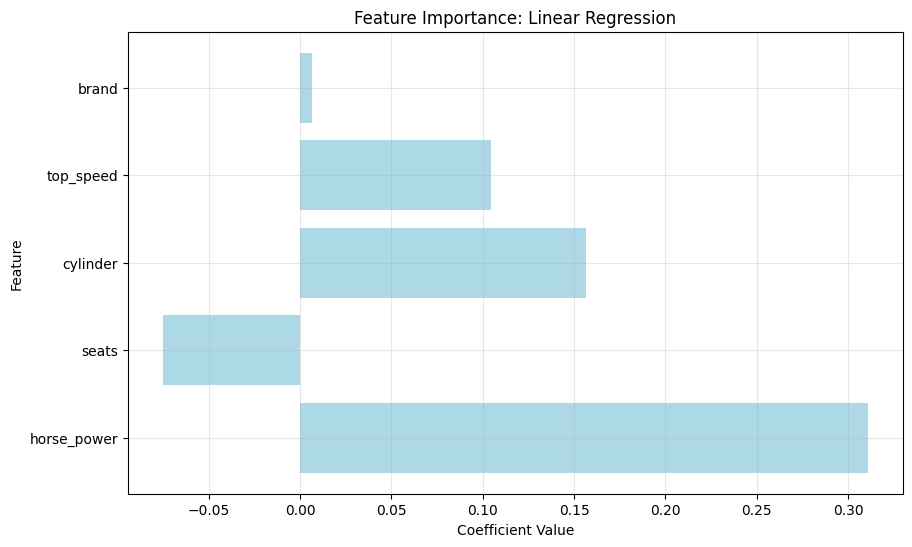

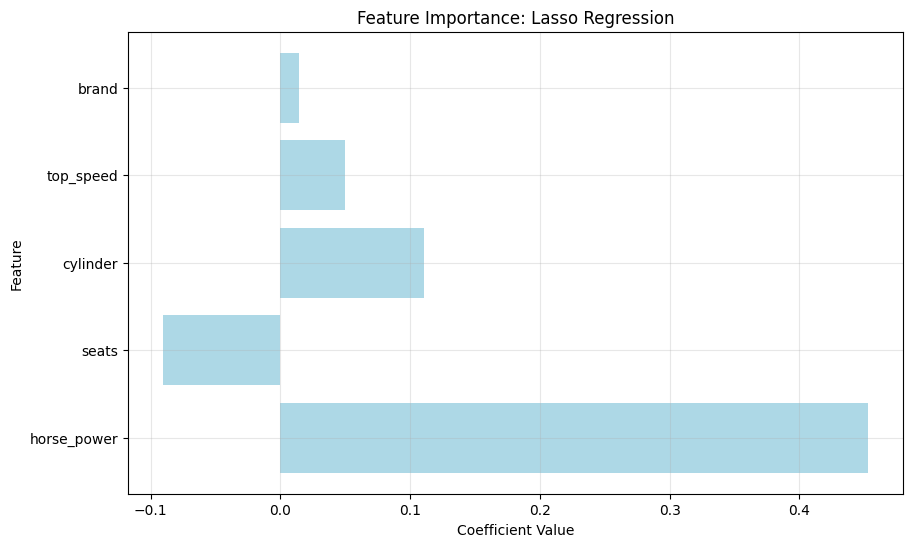

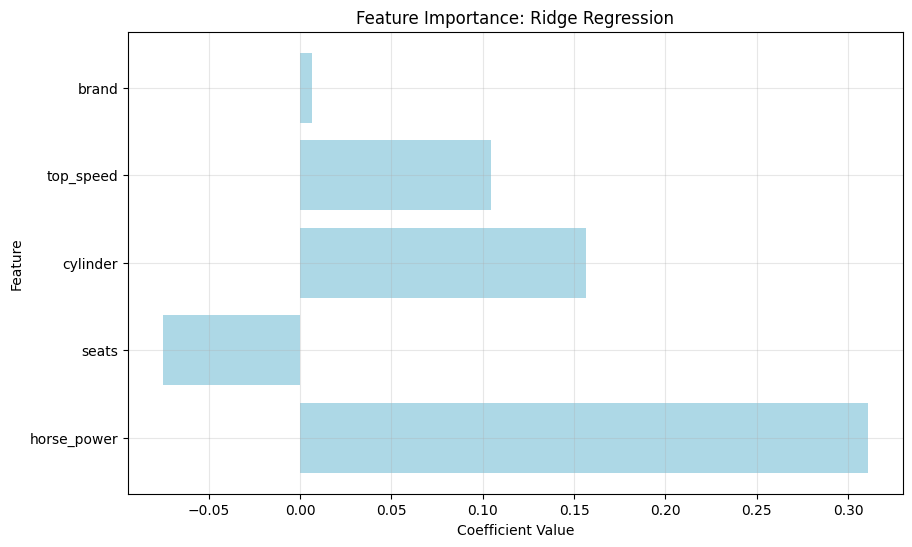

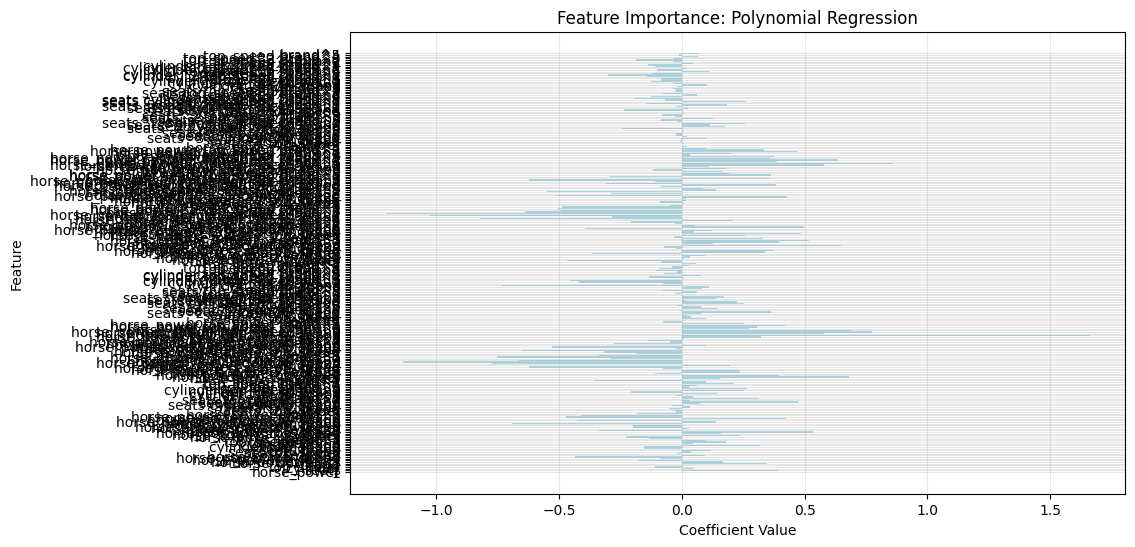

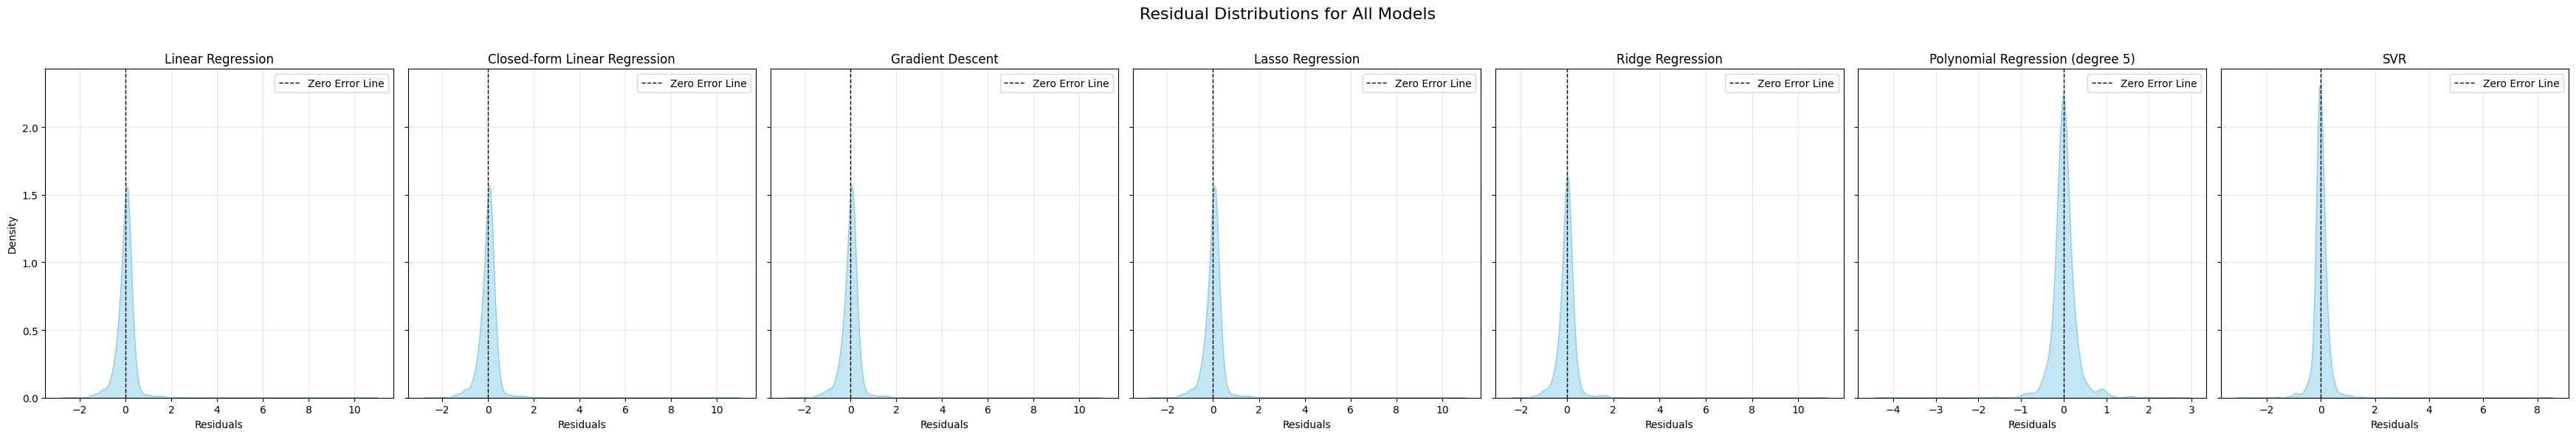

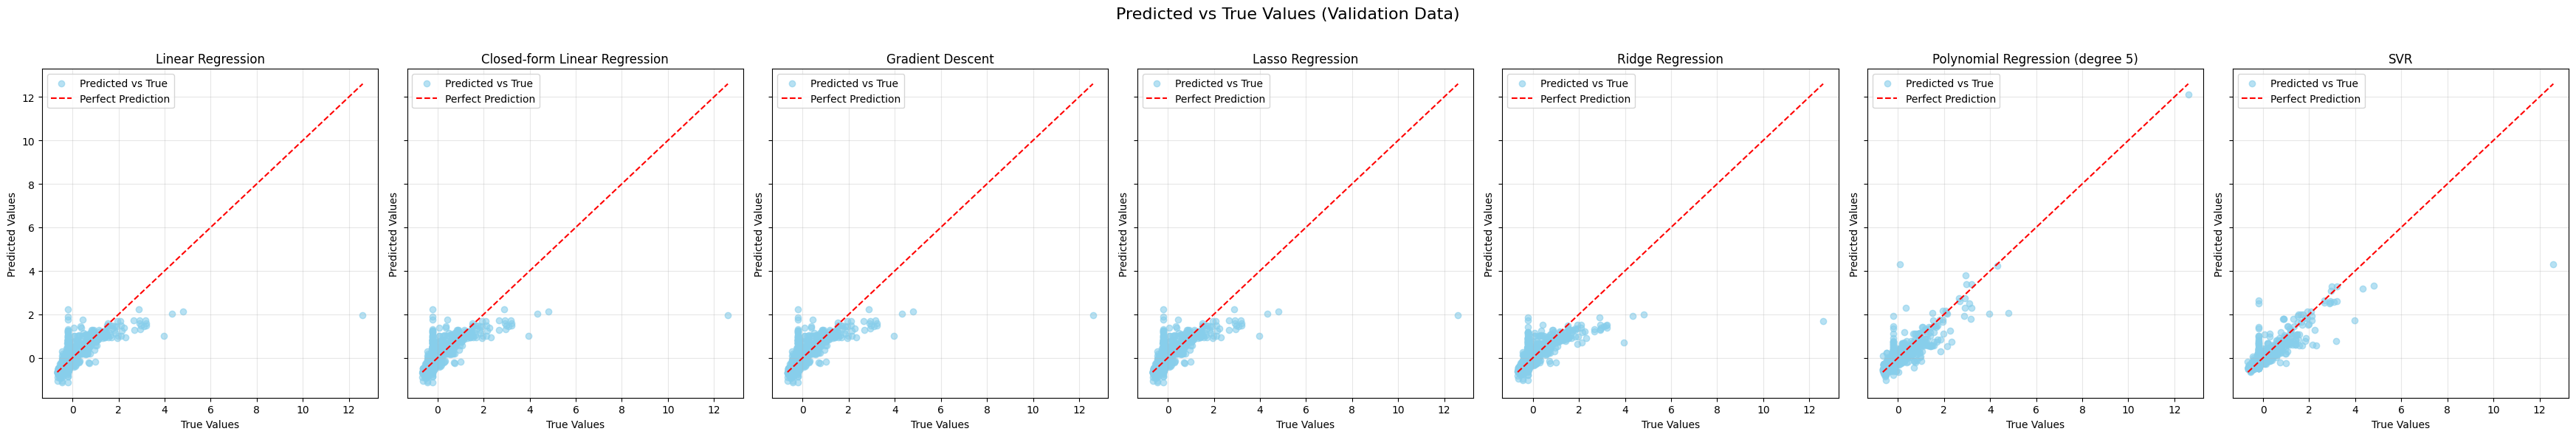

In [16]:
# Feature Importance for different models
selected_feature_names = ['horse_power', 'seats', 'cylinder', 'top_speed', 'brand']

for model_name, model in {
    "Linear Regression": model,
    "Lasso Regression": best_lasso,
    "Ridge Regression": best_ridge,
    "Polynomial Regression": poly_model,
}.items():
    if model is not None and hasattr(model, "coef_"):
        coefficients = model.coef_
        if "Polynomial Regression" in model_name:
            feature_labels = poly.get_feature_names_out(selected_feature_names)
        else:
            feature_labels = selected_feature_names

        plt.figure(figsize=(10, 6))
        plt.barh(feature_labels, coefficients, color='lightblue')
        plt.title(f"Feature Importance: {model_name}")
        plt.xlabel("Coefficient Value")
        plt.ylabel("Feature")
        plt.grid(alpha=0.3)
        plt.show()
    
# Error Distribution for all models in one layout
n_models = len(model_metrics)
fig, axes = plt.subplots(nrows=1, ncols=n_models, figsize=(5 * n_models, 6), sharey=True)
fig.suptitle("Residual Distributions for All Models", fontsize=16)

for ax, (model_name, metrics) in zip(axes, model_metrics.items()):
    sns.kdeplot(metrics["Residuals"], fill=True, alpha=0.5, ax=ax, color='skyblue')
    ax.set_title(f"{model_name}")
    ax.set_xlabel("Residuals")
    ax.axvline(0, color='black', linestyle='--', linewidth=1, label="Zero Error Line")
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Predicted vs True Values for all models
fig, axes = plt.subplots(nrows=1, ncols=n_models, figsize=(5 * n_models, 6), sharey=True)
fig.suptitle("Predicted vs True Values (Validation Data)", fontsize=16)

for ax, (model_name, metrics) in zip(axes, model_metrics.items()):
    y_pred = y_val - metrics["Residuals"]  # Calculate predicted values from residuals
    ax.scatter(y_val, y_pred, alpha=0.6, color='skyblue', label='Predicted vs True')
    ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='Perfect Prediction')
    ax.set_title(f"{model_name}" )
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

7. Model Evaluation on Test Set

Test Set Evaluation:
MSE: 0.6932431551422857
MAE: 0.22743722278974032
R²: 0.46119134728488154


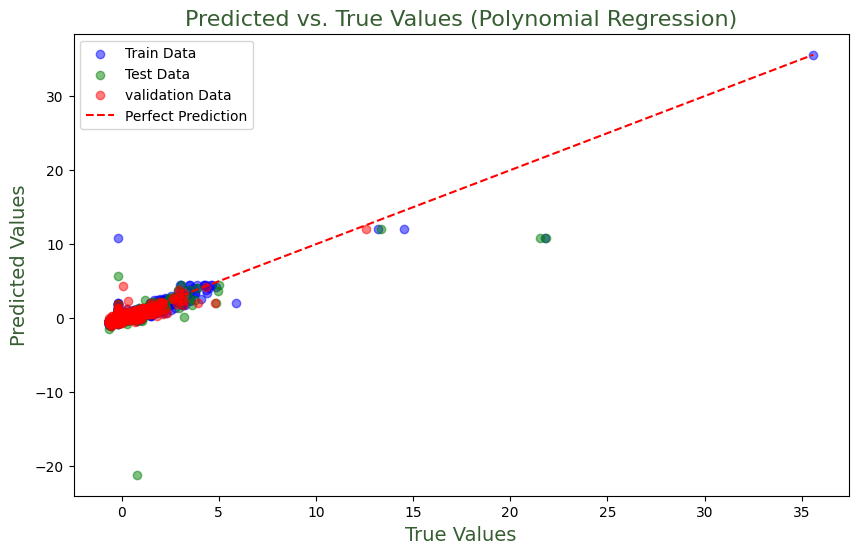

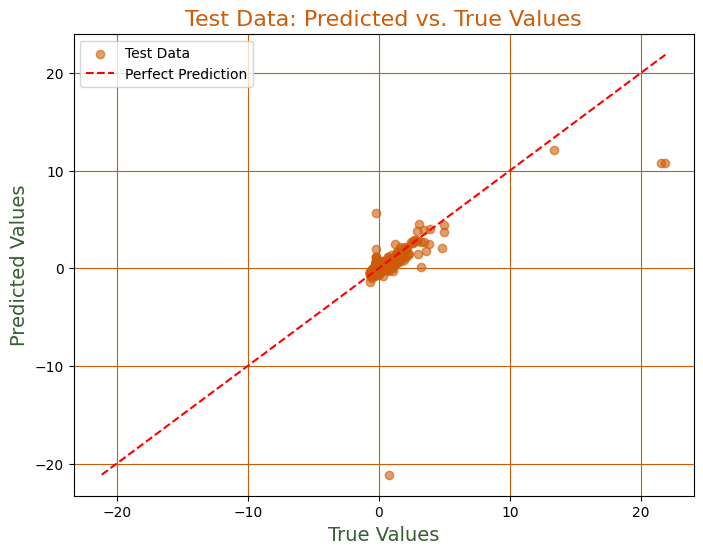

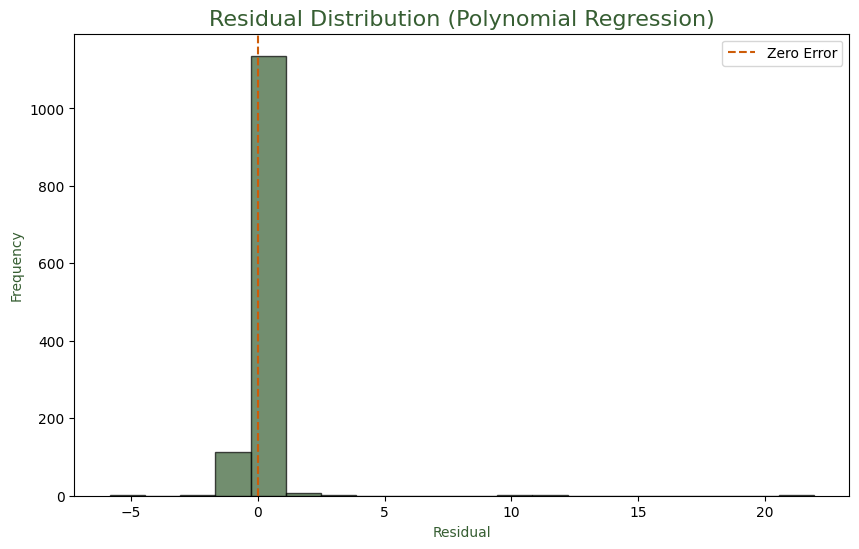

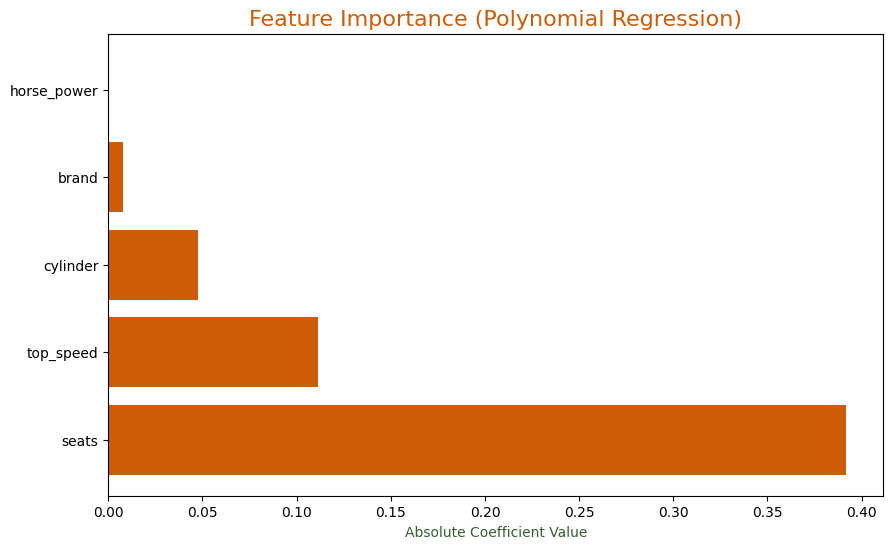

In [23]:
X_test_selected = X_test[:, selected_features]

# Feature transformation
poly_best = PolynomialFeatures(degree=5)
X_train_poly_best = poly_best.fit_transform(X_train_selected)
X_test_poly_best = poly_best.transform(X_test_selected)
X_val_poly_best = poly_best.transform(X_val_selected)

# Train the polynomial regression model
poly_model_best = LinearRegression()
poly_model_best.fit(X_train_poly_best, y_train)

# Predictions for train and test data
y_train_pred = poly_model_best.predict(X_train_poly_best)
y_test_pred = poly_model_best.predict(X_test_poly_best)
y_val_pred = poly_model_best.predict(X_val_poly_best)


# Plot the true values vs. predicted values for training and test data
plt.figure(figsize=(10, 6))

# Scatter plot for training data
plt.scatter(y_train, y_train_pred, color='blue', label='Train Data', alpha=0.5)

# Scatter plot for testing data
plt.scatter(y_test, y_test_pred, color='green', label='Test Data', alpha=0.5)

# Scatter plot for testing data
plt.scatter(y_val, y_val_pred, color='red', label='validation Data', alpha=0.5)

# Calculate MSE, MAE, and R² for the test set
mse_test = mean_squared_error(y_test, y_test_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Test Set Evaluation:")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"R²: {r2_test}")

# Plotting a line of perfect predictions
plt.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], 
         color='red', linestyle='--', label='Perfect Prediction')

# Title and labels
plt.title("Predicted vs. True Values (Polynomial Regression)", fontsize=16, color='#365E32')
plt.xlabel("True Values", fontsize=14, color='#365E32')
plt.ylabel("Predicted Values", fontsize=14, color='#365E32')
plt.legend()
plt.show()


# Test Data Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred, color='#CD5C08', label='Test Data', alpha=0.6)
plt.plot([min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())], 
         [min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())], 
         color='red', linestyle='--', label='Perfect Prediction')
plt.title("Test Data: Predicted vs. True Values", fontsize=16, color='#CD5C08')
plt.xlabel("True Values", fontsize=14, color='#365E32')
plt.ylabel("Predicted Values", fontsize=14, color='#365E32')
plt.legend()
plt.grid(True, color='#CD5C08')
plt.show()


# Residuals for error distribution
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color='#365E32', edgecolor='black', alpha=0.7)
plt.xlabel('Residual', color='#365E32')
plt.ylabel('Frequency', color='#365E32')
plt.title('Residual Distribution (Polynomial Regression)', fontsize=16, color='#365E32')
plt.axvline(0, color='#CD5C08', linestyle='--', label='Zero Error')
plt.legend()
plt.show()

selected_feature_indices = [2, 4, 1, 3, 5]
selected_feature_names = ['horse_power', 'seats', 'cylinder', 'top_speed', 'brand']
coefficients = poly_model_best.coef_
# Map the coefficients to the selected feature names
feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Coefficient': coefficients[:len(selected_feature_names)]
})
feature_importance_df['Abs_Coefficient'] = feature_importance_df['Coefficient'].abs()
feature_importance_df = feature_importance_df.sort_values(by='Abs_Coefficient', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Abs_Coefficient'], color='#CD5C08')
plt.xlabel('Absolute Coefficient Value', color='#365E32')
plt.title('Feature Importance (Polynomial Regression)', fontsize=16, color='#CD5C08')
plt.show()

8. Optional

8.1. Choose "horse power" as a target and apply the feature selection function another time

/n find best polynomial degree
Adding feature 1 gives MSE: 0.5542034722225698
Adding feature 6 gives MSE: 0.34857105773047214
Adding feature 2 gives MSE: 0.2640893255386117
Adding feature 0 gives MSE: 0.2557310112624173
Adding feature 3 gives MSE: 0.25422084314212656
Best feature set: [1, 6, 2, 0, 3]
Selected Features: Index(['cylinder', 'price_in_usd', 'top_speed', 'engine_capacity', 'seats'], dtype='object')
Degree 2 - MSE for Polynomial Regression: 0.12245193628470984
Degree 3 - MSE for Polynomial Regression: 0.11781096853528973
Degree 4 - MSE for Polynomial Regression: 0.09664933298072884
Degree 5 - MSE for Polynomial Regression: 0.8567743768087323
Degree 6 - MSE for Polynomial Regression: 8.326330604845888
Degree 7 - MSE for Polynomial Regression: 9125.3913313613
Degree 8 - MSE for Polynomial Regression: 36409519.52924298
Degree 9 - MSE for Polynomial Regression: 18567101.145813383
Degree 10 - MSE for Polynomial Regression: 362680.97183331446
Best degree for Polynomial Regression:

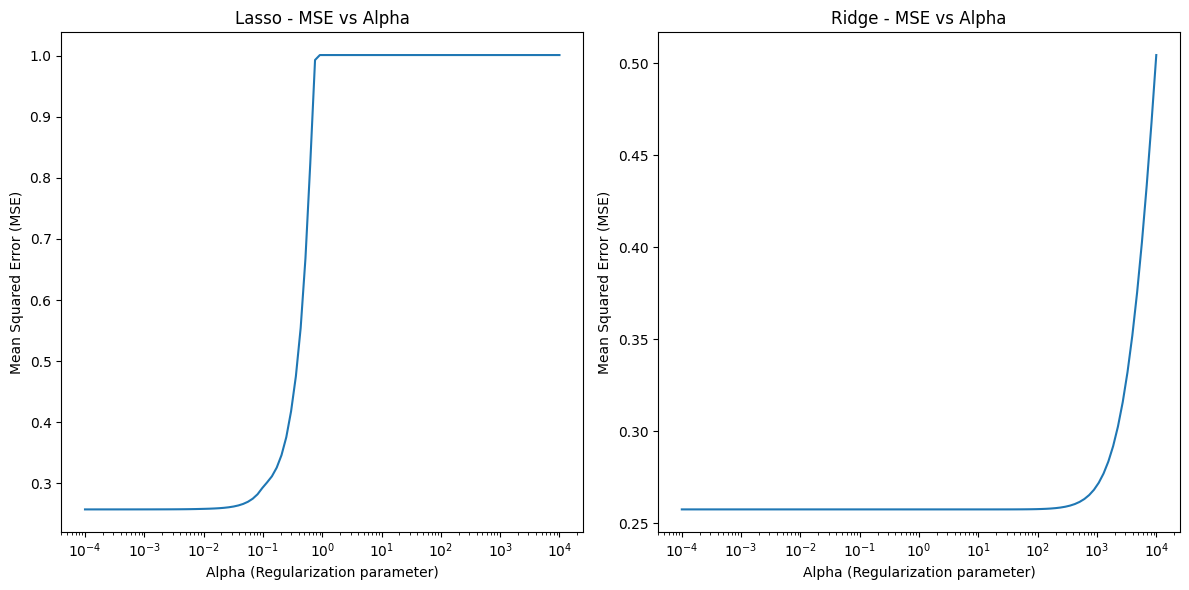

In [26]:
# Target variable: horse_power
X_optional = df.drop(['car name', 'horse_power'], axis=1)
y_optional = df['horse_power']

# Split the temporary data (40%) into validation (20%) and test (20%) sets
X_train_optional, X_temp_optional, y_train_optional, y_temp_optional = train_test_split(X_optional, y_optional, test_size=0.4, random_state=42)
X_val_optional, X_test_optional, y_val_optional, y_test_optional = train_test_split(X_temp_optional, y_temp_optional, test_size=0.5, random_state=42)

# Standardize the features
scaler_optional = StandardScaler()
X_train_scaled_optional = scaler_optional.fit_transform(X_train_optional)
X_val_scaled_optional = scaler_optional.transform(X_val_optional)
X_test_scaled_optional = scaler_optional.transform(X_test_optional)

# Scale the target variable (y)
target_scaler_optional = StandardScaler()
y_train_optional = target_scaler_optional.fit_transform(y_train_optional.values.reshape(-1, 1)).flatten()
y_val_optional = target_scaler_optional.transform(y_val_optional.values.reshape(-1, 1)).flatten()
y_test_optional = target_scaler_optional.transform(y_test_optional.values.reshape(-1, 1)).flatten()

print("/n find best polynomial degree")
# Perform Forward Selection
selected_features, mse_values, feature_importances = forward_selection(X_train_scaled_optional, y_train_optional, X_test_scaled_optional, y_test_optional, max_features=5)
#selected_features, mse_values = forward_selection(X_train_scaled_optional, y_train_optional, X_test_scaled_optional, y_test_optional, max_features=5)

# Map selected feature indices to their corresponding feature names
selected_feature_names = X_optional.columns[selected_features]
print("Selected Features:", selected_feature_names)

# Feature selection
X_train_selected_optional = X_train_scaled_optional[:, selected_features]
X_val_selected_optional = X_val_scaled_optional[:, selected_features]
X_test_selected_optional = X_test_scaled_optional[:, selected_features]

best_degree, best_mse_poly, best_svr_model, mse_svr, mse_poly_values, best_C = tune_models(X_train_selected_optional, y_train_optional, X_val_selected_optional, y_val_optional)
best_lasso, best_ridge, mse_lasso, mse_ridge = regularization(X_train_selected_optional, y_train_optional, X_val_selected_optional, y_val_optional)


8.2. Model Selection Using Validation Set

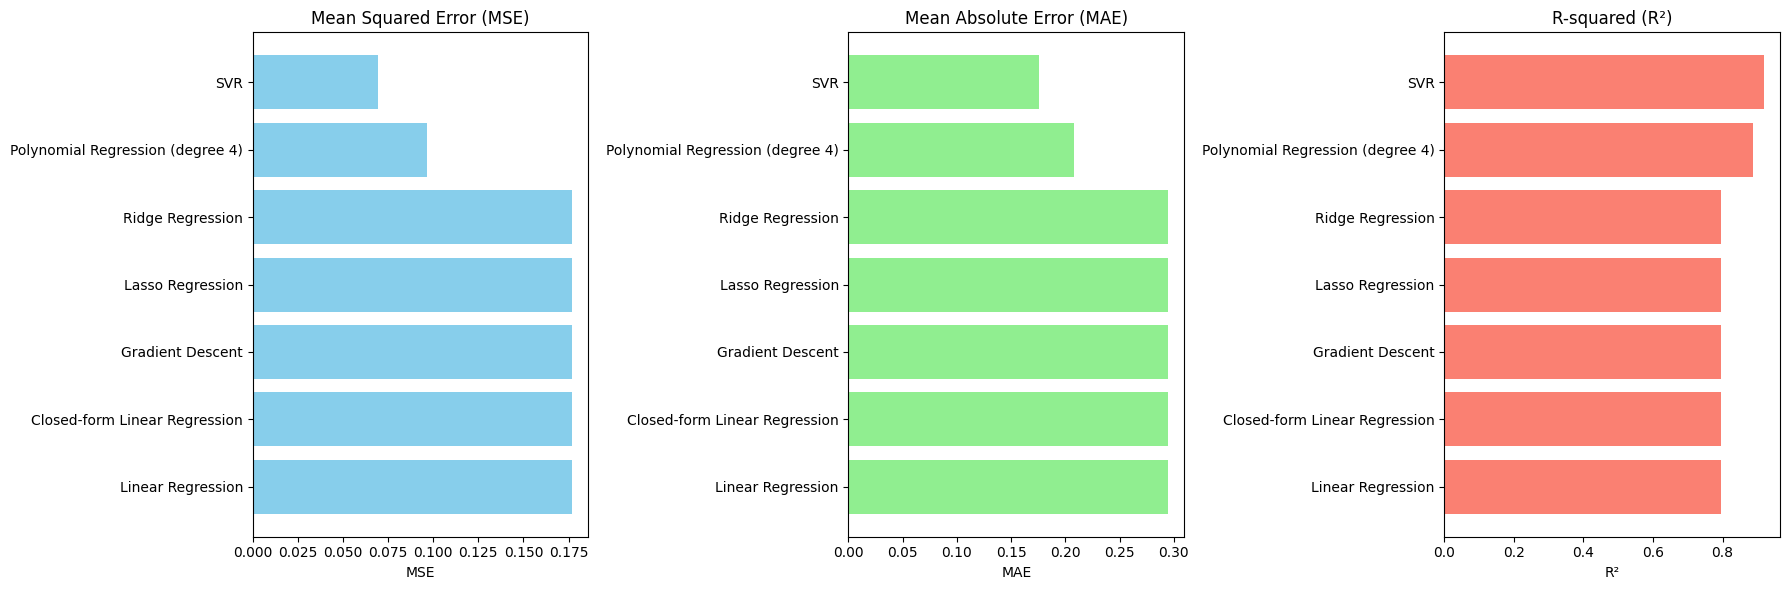

                                       MSE       MAE        R2
Linear Regression                 0.176987  0.294601  0.794409
Closed-form Linear Regression     0.176987  0.294601  0.794409
Gradient Descent                  0.176980  0.294588  0.794417
Lasso Regression                  0.177002  0.294633  0.794391
Ridge Regression                  0.177034  0.294774  0.794354
Polynomial Regression (degree 4)  0.096649  0.207631  0.887730
SVR                               0.069493  0.175939  0.919275


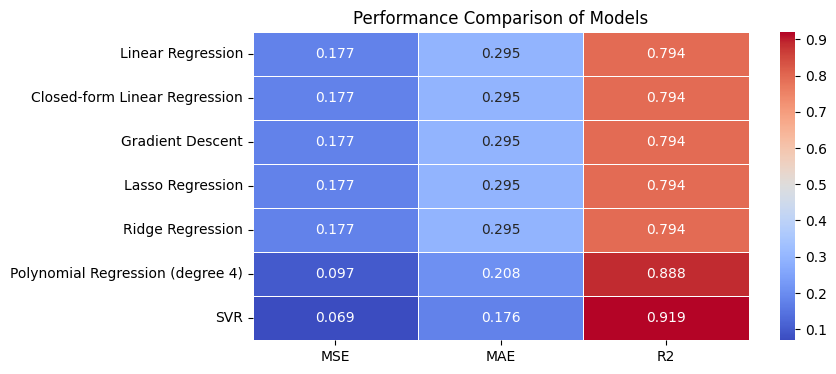

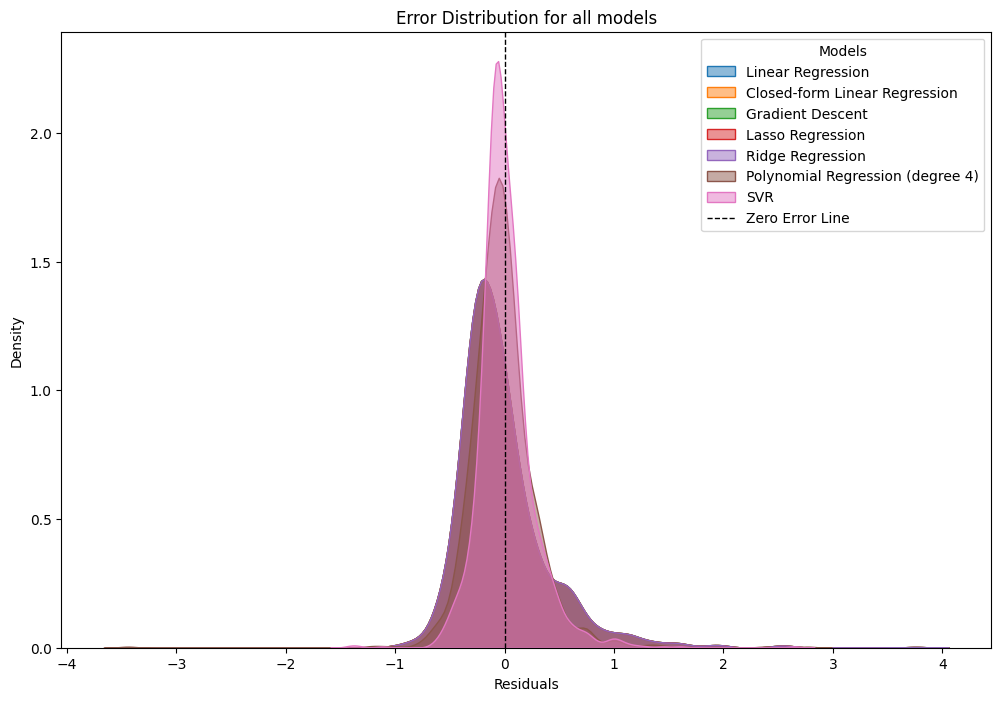


Best Model: SVR - MSE: 0.06949327336975487, MAE: 0.1759392845463773, R²: 0.9192753778472724


In [27]:
def evaluate_model(model_name, y_true, y_pred):
    residuals = y_true - y_pred  # Calculate residuals
    metrics = {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred),
        "Residuals": residuals
    }
    #print(f"{model_name} - MSE: {metrics['MSE']}, MAE: {metrics['MAE']}, R²: {metrics['R2']}")
    return metrics

model_metrics = {}


# Linear Regression (Scikit-learn)
model_lr = LinearRegression().fit(X_train_selected_optional, y_train_optional)
model_metrics["Linear Regression"] = evaluate_model("Linear Regression", y_val_optional, model_lr.predict(X_val_selected_optional))

# Closed-form Linear Regression
X_train_bias = np.c_[np.ones(X_train_selected_optional.shape[0]), X_train_selected_optional]
X_val_bias = np.c_[np.ones(X_val_selected_optional.shape[0]), X_val_selected_optional]
theta = np.linalg.inv(X_train_bias.T @ X_train_bias) @ X_train_bias.T @ y_train_optional
model_metrics["Closed-form Linear Regression"] = evaluate_model("Closed-form Linear Regression", y_val_optional, X_val_bias @ theta)

# Gradient Descent Linear Regression
def predict(X, theta):
    X_bias = np.c_[np.ones(X.shape[0]), X]
    return X_bias @ theta
theta_gd = linear_regression_gradient_descent(X_train_selected_optional, y_train_optional)
y_val_pred_gd = predict(X_val_selected_optional, theta_gd)
model_metrics["Gradient Descent"] = evaluate_model("Gradient Descent", y_val_optional, y_val_pred_gd)

# Lasso and Ridge Regression
for model_name, model in {"Lasso": best_lasso, "Ridge": best_ridge}.items():
    model_metrics[f"{model_name} Regression"] = evaluate_model(
        f"{model_name} Regression", y_val_optional, model.predict(X_val_selected_optional)
    )

# Polynomial Regression
best_degree = 4
poly = PolynomialFeatures(degree=best_degree)
X_train_poly, X_val_poly = poly.fit_transform(X_train_selected_optional), poly.transform(X_val_selected_optional)
poly_model = LinearRegression().fit(X_train_poly, y_train_optional)
model_metrics[f"Polynomial Regression (degree {best_degree})"] = evaluate_model(f"Polynomial Regression (degree {best_degree})", y_val_optional, poly_model.predict(X_val_poly))

# Support Vector Regression (SVR)
model_metrics["SVR"] = evaluate_model("SVR", y_val_optional, best_svr_model.predict(X_val_selected_optional))

# Bar Plot for Comparison of MSE, MAE, and R²
models = list(model_metrics.keys())
mse_values = [model_metrics[model]["MSE"] for model in models]
mae_values = [model_metrics[model]["MAE"] for model in models]
r2_values = [model_metrics[model]["R2"] for model in models]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].barh(models, mse_values, color='skyblue')
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_xlabel('MSE')

axes[1].barh(models, mae_values, color='lightgreen')
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_xlabel('MAE')

axes[2].barh(models, r2_values, color='salmon')
axes[2].set_title('R-squared (R²)')
axes[2].set_xlabel('R²')

plt.tight_layout()
plt.show()

# Table Summarizing the Performance of Each Regression Model
performance_df = pd.DataFrame.from_dict(model_metrics, orient='index', columns=['MSE', 'MAE', 'R2'])
print(performance_df)
# Heatmap of Model Performance
plt.figure(figsize=(8, 4))
sns.heatmap(performance_df, annot=True, cmap='coolwarm', fmt='.3f', cbar=True, linewidths=0.5)
plt.title('Performance Comparison of Models')
plt.show()

# Residual Distributions for All Models
plt.figure(figsize=(12, 8))
for model_name, metrics in model_metrics.items():sns.kdeplot(metrics["Residuals"], label=model_name, fill=True, alpha=0.5)
plt.title("Error Distribution for all models")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.axvline(0, color='black', linestyle='--', linewidth=1, label="Zero Error Line")
plt.legend(title="Models")
plt.show()


# Find Best Model
best_model = min(model_metrics, key=lambda m: model_metrics[m]["MSE"])
best_metrics = model_metrics[best_model]

print(f"\nBest Model: {best_model} - MSE: {best_metrics['MSE']}, MAE: {best_metrics['MAE']}, R²: {best_metrics['R2']}")


Visualization

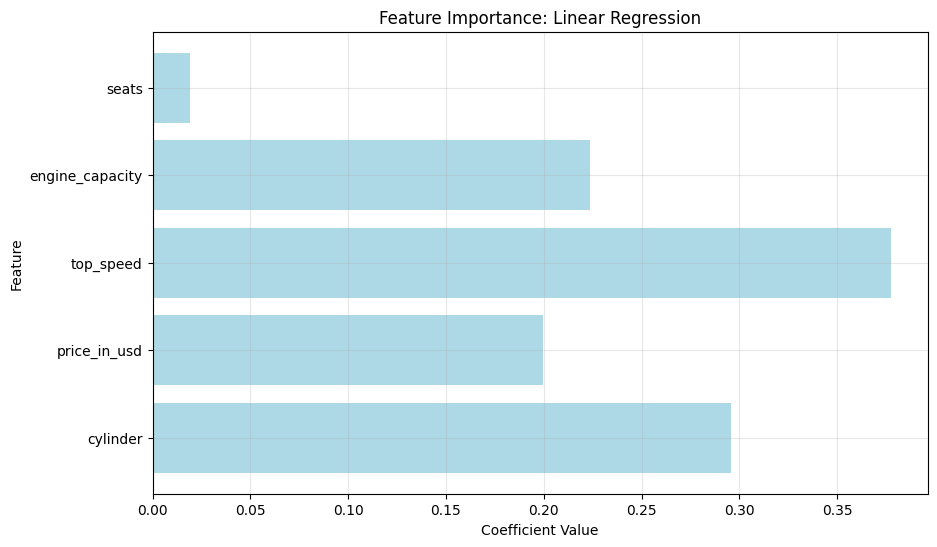

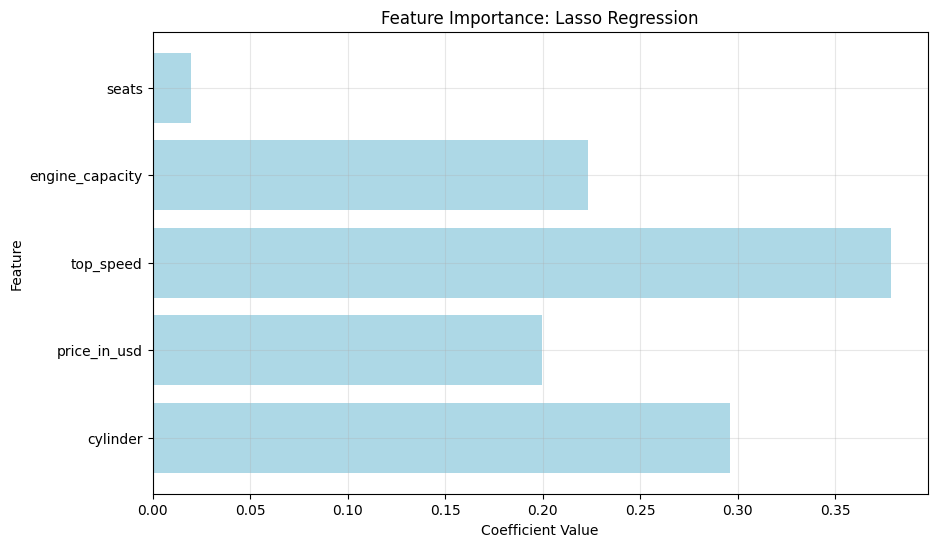

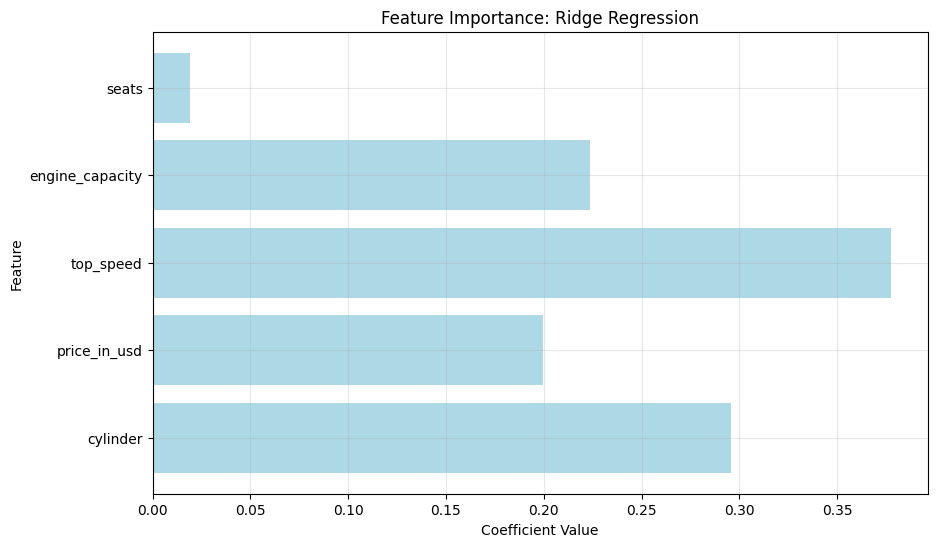

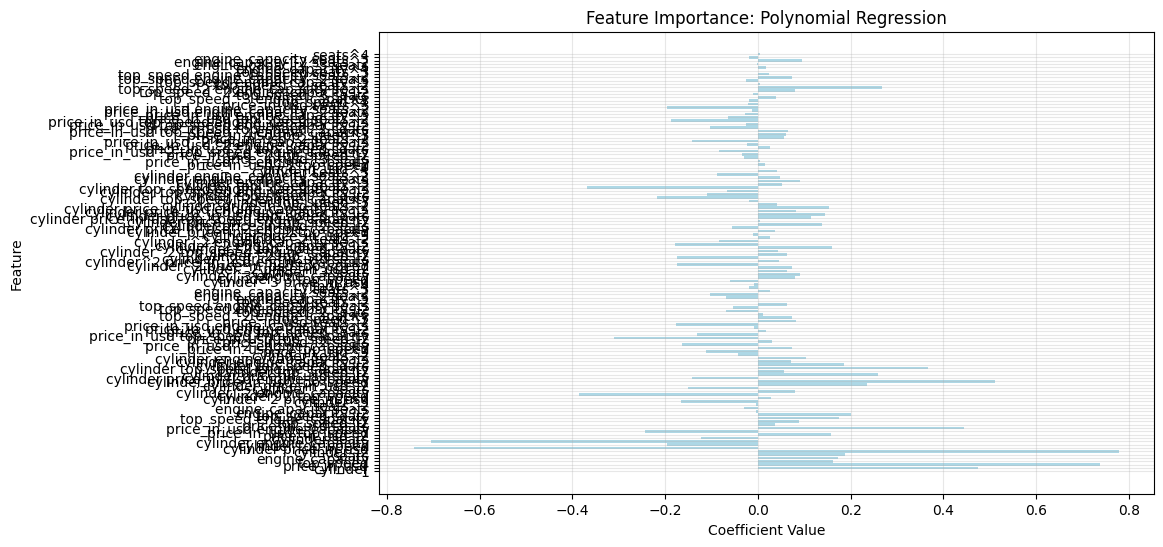

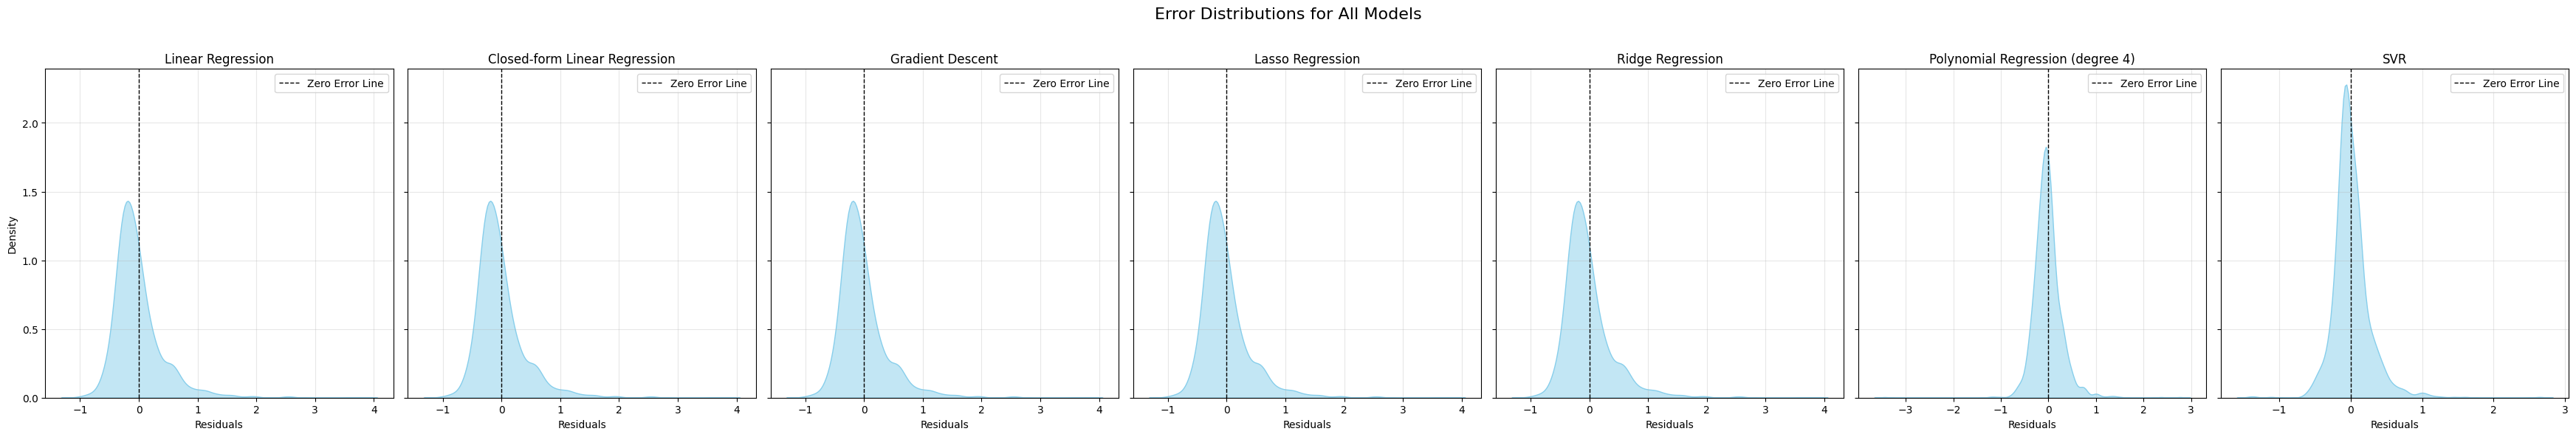

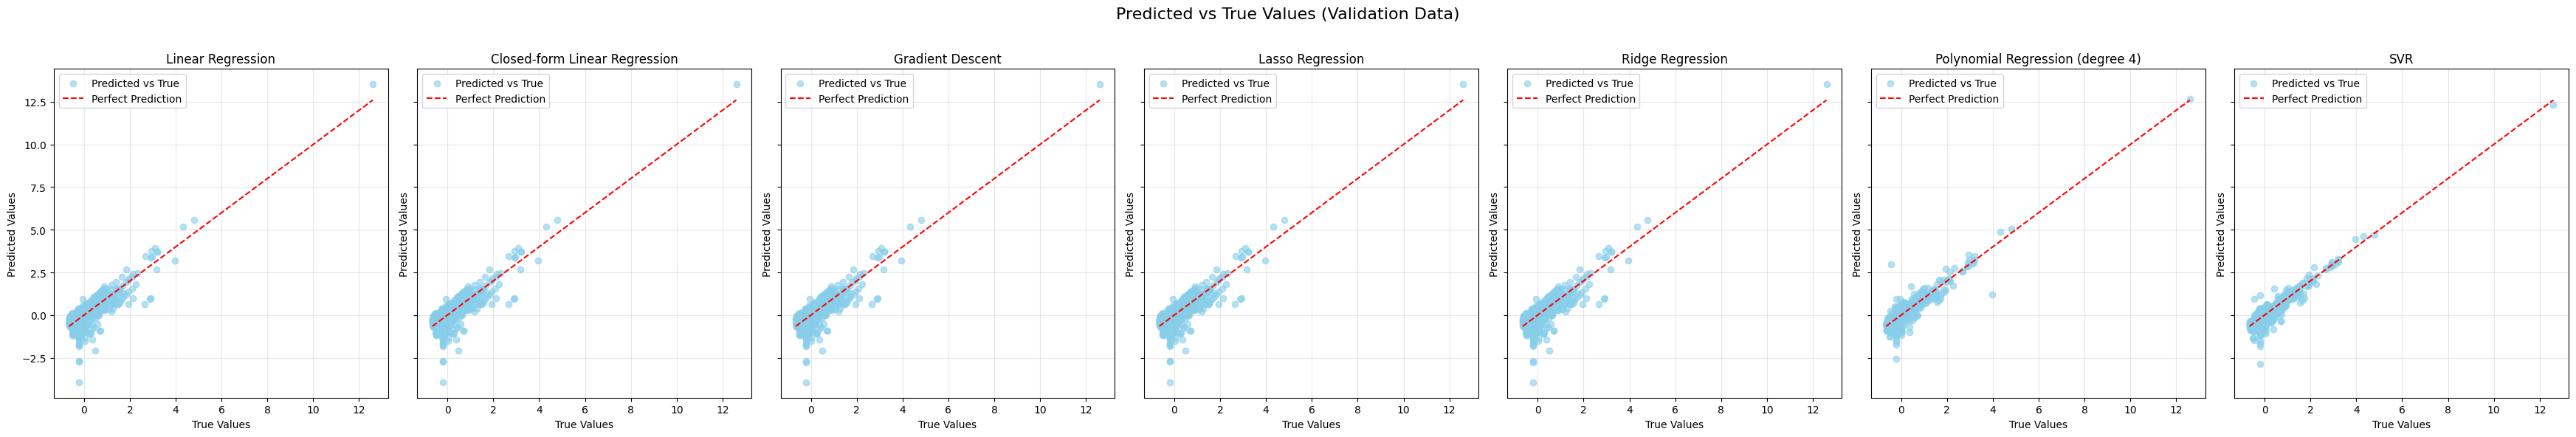

In [28]:
# Feature Importance
feature_names = ['cylinder', 'price_in_usd', 'top_speed', 'engine_capacity', 'seats']

for model_name, model in {
    "Linear Regression": model,
    "Lasso Regression": best_lasso,
    "Ridge Regression": best_ridge,
    "Polynomial Regression": poly_model,
}.items():
    if model is not None and hasattr(model, "coef_"):
        coefficients = model.coef_
        if "Polynomial Regression" in model_name:
            feature_labels = poly.get_feature_names_out(feature_names)
        else:
            feature_labels = feature_names

        plt.figure(figsize=(10, 6))
        plt.barh(feature_labels, coefficients, color='lightblue')
        plt.title(f"Feature Importance: {model_name}")
        plt.xlabel("Coefficient Value")
        plt.ylabel("Feature")
        plt.grid(alpha=0.3)
        plt.show()

    
# Error Distribution for all models in one layout
n_models = len(model_metrics)
fig, axes = plt.subplots(nrows=1, ncols=n_models, figsize=(5 * n_models, 6), sharey=True)
fig.suptitle("Error Distributions for All Models", fontsize=16)

for ax, (model_name, metrics) in zip(axes, model_metrics.items()):
    sns.kdeplot(metrics["Residuals"], fill=True, alpha=0.5, ax=ax, color='skyblue')
    ax.set_title(f"{model_name}")
    ax.set_xlabel("Residuals")
    ax.axvline(0, color='black', linestyle='--', linewidth=1, label="Zero Error Line")
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Predicted vs True Values for all models
fig, axes = plt.subplots(nrows=1, ncols=n_models, figsize=(5 * n_models, 6), sharey=True)
fig.suptitle("Predicted vs True Values (Validation Data)", fontsize=16)

for ax, (model_name, metrics) in zip(axes, model_metrics.items()):
    y_pred = y_val - metrics["Residuals"]  # Calculate predicted values from residuals
    ax.scatter(y_val, y_pred, alpha=0.6, color='skyblue', label='Predicted vs True')
    ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', label='Perfect Prediction')
    ax.set_title(f"{model_name}" )
    ax.set_xlabel("True Values")
    ax.set_ylabel("Predicted Values")
    ax.grid(alpha=0.3)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

8.3. Apply best model(SVR) to the test set

Training Set Evaluation (Best Model SVR):
MSE: 0.08413914753904664
MAE: 0.1775438893618118
R²: 0.9158608524609533

Validation Set Evaluation (Best Model SVR):
MSE: 0.06949327336975487
MAE: 0.1759392845463773
R²: 0.9192753778472724

Test Set Evaluation (Best Model SVR):
MSE: 0.07302629788581479
MAE: 0.17879329998833335
R²: 0.931158254623529


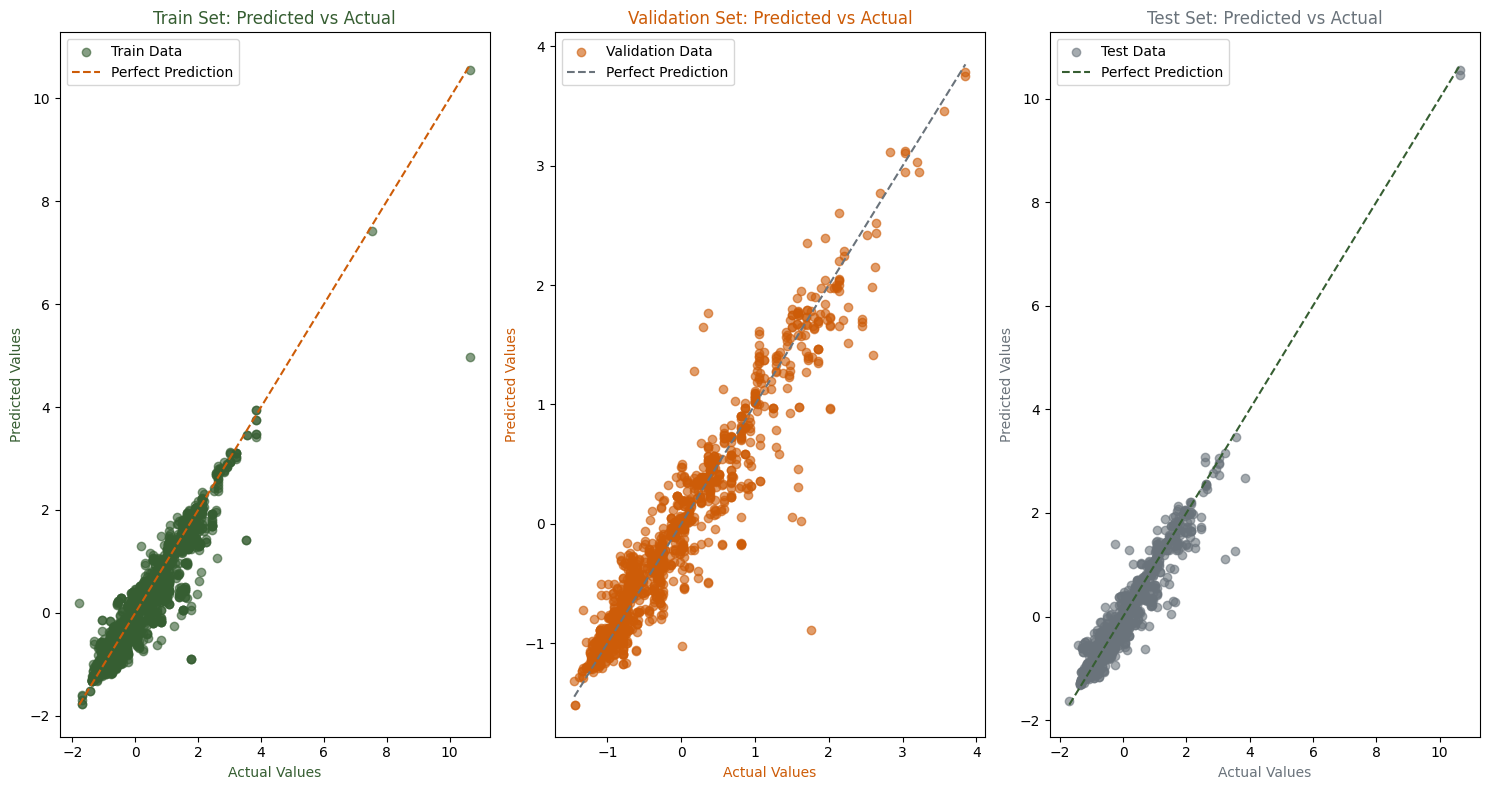

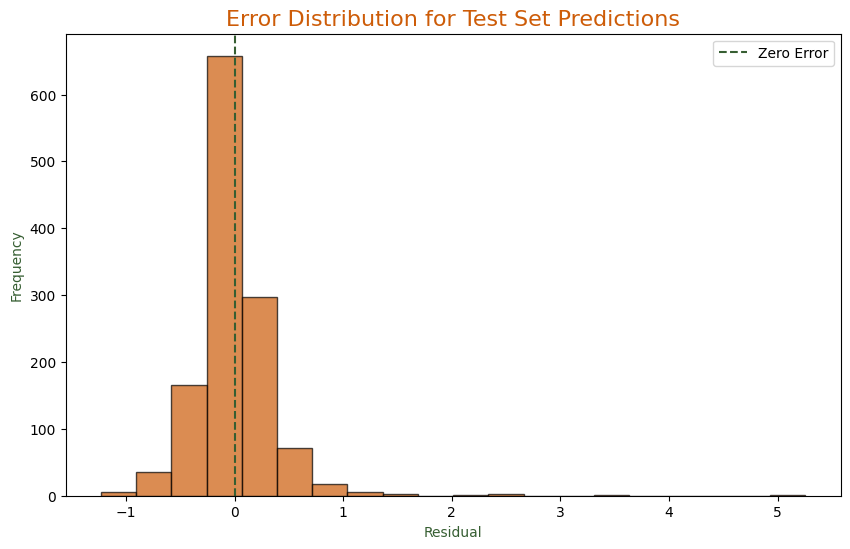

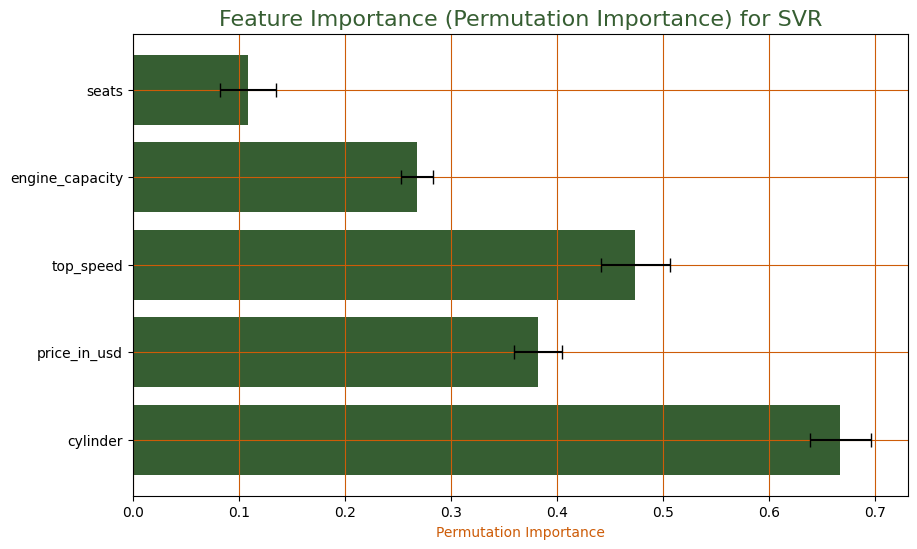

In [30]:
from sklearn.inspection import permutation_importance
y_test_pred_svr = best_svr_model.predict(X_test_selected_optional)
y_val_pred_svr = best_svr_model.predict(X_val_selected_optional)
y_train_pred_svr = best_svr_model.predict(X_train_selected_optional)

# Make predictions
mse_test_svr = mean_squared_error(y_test_optional, y_test_pred_svr)
mae_test_svr = mean_absolute_error(y_test_optional, y_test_pred_svr)
r2_test_svr = r2_score(y_test_optional, y_test_pred_svr)

# Evaluate the model
mse_train = mean_squared_error(y_train_optional, y_train_pred_svr)
mae_train = mean_absolute_error(y_train_optional, y_train_pred_svr)
r2_train = r2_score(y_train_optional, y_train_pred_svr)

mse_val = mean_squared_error(y_val_optional, y_val_pred_svr)
mae_val = mean_absolute_error(y_val_optional, y_val_pred_svr)
r2_val = r2_score(y_val_optional, y_val_pred_svr)

mse_test = mean_squared_error(y_test_optional, y_test_pred_svr)
mae_test = mean_absolute_error(y_test_optional, y_test_pred_svr)
r2_test = r2_score(y_test_optional, y_test_pred_svr)

# Print results
print(f"Training Set Evaluation (Best Model SVR):")
print(f"MSE: {mse_train}")
print(f"MAE: {mae_train}")
print(f"R²: {r2_train}\n")

print(f"Validation Set Evaluation (Best Model SVR):")
print(f"MSE: {mse_val}")
print(f"MAE: {mae_val}")
print(f"R²: {r2_val}\n")

print(f"Test Set Evaluation (Best Model SVR):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"R²: {r2_test}")

# Plot the predicted vs actual values for train, validation, and test sets
plt.figure(figsize=(15, 8))

# Plot for Train set
plt.subplot(1, 3, 1)
plt.scatter(y_train_optional, y_train_pred_svr, color='#365E32', label='Train Data', alpha=0.6) 
plt.plot([min(y_train_optional), max(y_train_optional)], [min(y_train_optional), max(y_train_optional)], 
         color='#CD5C08', linestyle='--', label="Perfect Prediction") 
plt.xlabel('Actual Values', color='#365E32')
plt.ylabel('Predicted Values', color='#365E32')
plt.title('Train Set: Predicted vs Actual', color='#365E32')
plt.legend()

# Plot for Validation set
plt.subplot(1, 3, 2)
plt.scatter(y_val_optional, y_val_pred_svr, color='#CD5C08', label='Validation Data', alpha=0.6)
plt.plot([min(y_val_optional), max(y_val_optional)], [min(y_val_optional), max(y_val_optional)], 
         color='#6A737B', linestyle='--', label="Perfect Prediction")  
plt.xlabel('Actual Values', color='#CD5C08')
plt.ylabel('Predicted Values', color='#CD5C08')
plt.title('Validation Set: Predicted vs Actual', color='#CD5C08')
plt.legend()

# Plot for Test set
plt.subplot(1, 3, 3)
plt.scatter(y_test_optional, y_test_pred_svr, color='#6A737B', label='Test Data', alpha=0.6) 
plt.plot([min(y_test_optional), max(y_test_optional)], [min(y_test_optional), max(y_test_optional)], 
         color='#365E32', linestyle='--', label="Perfect Prediction")
plt.xlabel('Actual Values', color='#6A737B')
plt.ylabel('Predicted Values', color='#6A737B')
plt.title('Test Set: Predicted vs Actual', color='#6A737B')
plt.legend()

plt.tight_layout()
plt.show()

#  Error Distribution
y_test_pred_svr = poly_model.predict(poly.transform(X_test_selected_optional))
residuals = y_test_optional - y_test_pred_svr
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color='#CD5C08', edgecolor='black', alpha=0.7)  
plt.xlabel('Residual', color='#365E32')
plt.ylabel('Frequency', color='#365E32')
plt.title('Error Distribution for Test Set Predictions', fontsize=16, color='#CD5C08')
plt.axvline(0, color='#365E32', linestyle='--', label='Zero Error') 
plt.legend()
plt.show()

perm_importance = permutation_importance(best_svr_model, X_test_selected_optional, y_test_optional, n_repeats=10, random_state=42)
# Extract the feature importances and their standard deviations
feature_importances = perm_importance.importances_mean
feature_importance_std = perm_importance.importances_std
# Plot feature importance with standard deviation
plt.figure(figsize=(10, 6))
plt.barh(['cylinder', 'price_in_usd', 'top_speed', 'engine_capacity', 'seats'], feature_importances, 
         xerr=feature_importance_std, color='#365E32', capsize=5)  
plt.xlabel('Permutation Importance', color='#CD5C08')
plt.title('Feature Importance (Permutation Importance) for SVR', fontsize=16, color='#365E32')
plt.grid(True, color='#CD5C08') 
plt.show()

8.4. Apply best polynomial degree on test set

Training Set Evaluation (Best Polynomial Model):
MSE: 0.09252194784710985
MAE: 0.21133212143068153
R²: 0.9074780521528901

Validation Set Evaluation (Best Polynomial Model):
MSE: 0.09664933298072884
MAE: 0.2076305849211236
R²: 0.8877304160840106

Test Set Evaluation (Best Polynomial Model):
MSE: 0.13420489205081282
MAE: 0.2302793686169654
R²: 0.8734853159161247


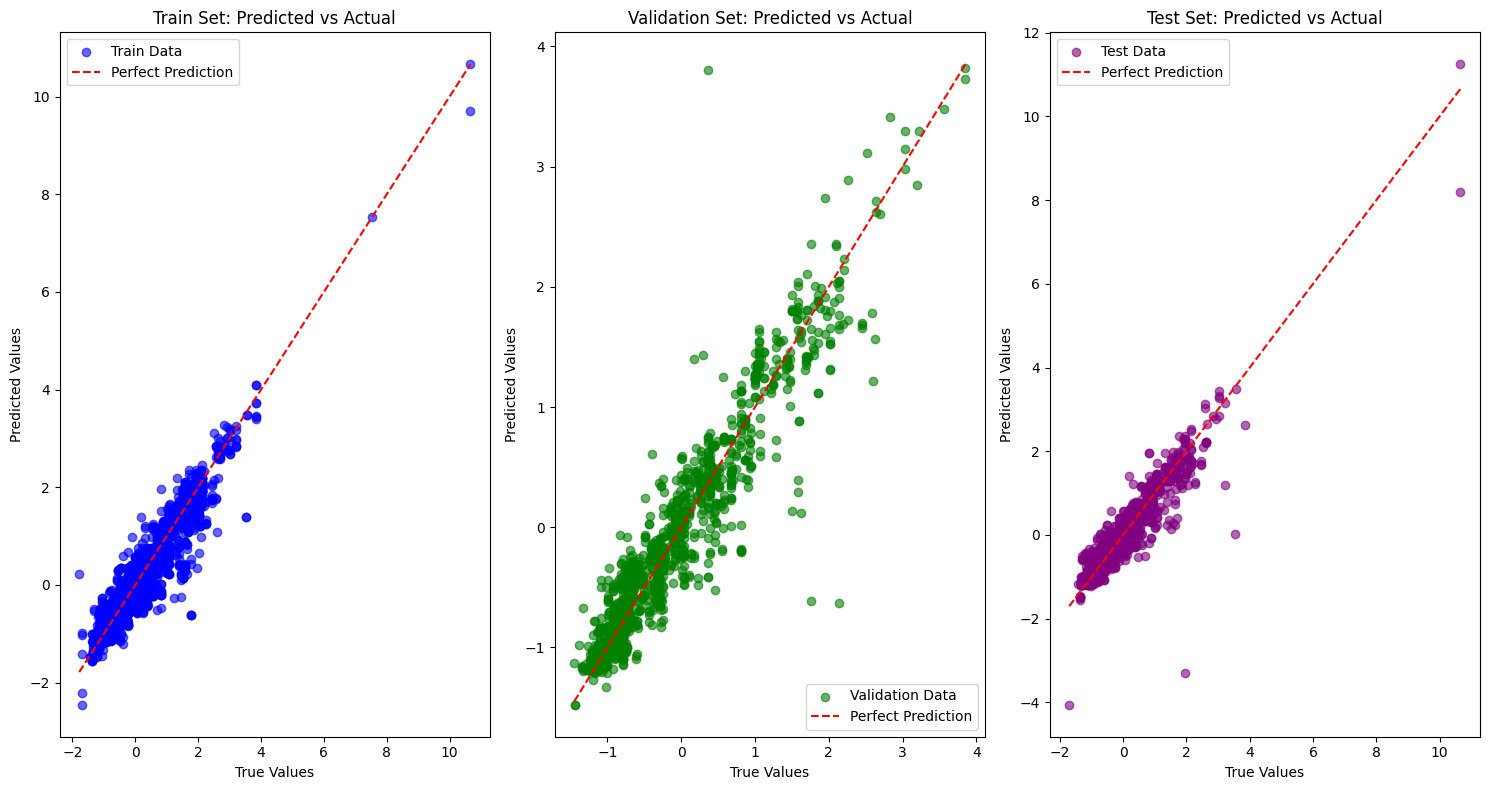

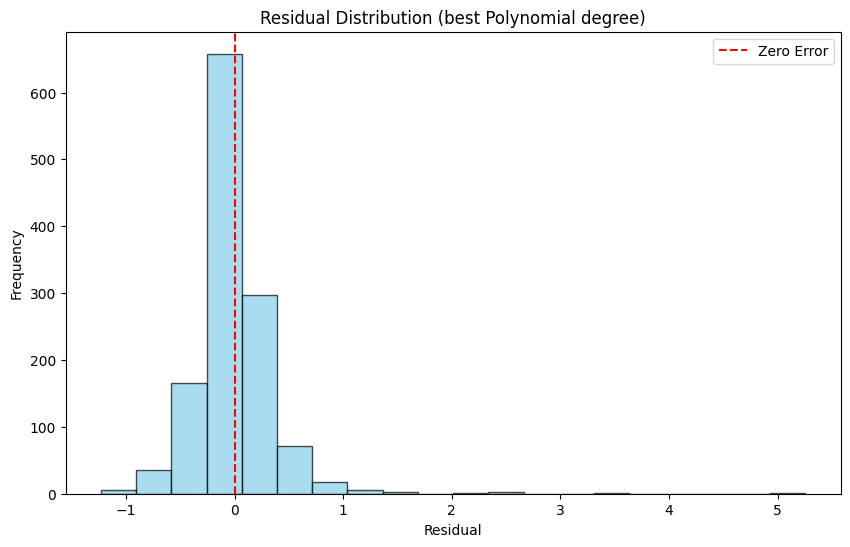

In [31]:
poly_best = PolynomialFeatures(degree=4)
X_train_poly_best = poly_best.fit_transform(X_train_selected_optional)
X_val_poly_best = poly_best.transform(X_val_selected_optional)
X_test_poly_best = poly_best.transform(X_test_selected_optional)

# Train the model
poly_model_best = LinearRegression()
poly_model_best.fit(X_train_poly_best, y_train_optional)

# Make predictions
y_train_pred = poly_model_best.predict(X_train_poly_best)
y_val_pred = poly_model_best.predict(X_val_poly_best)
y_test_pred = poly_model_best.predict(X_test_poly_best)

# Evaluate the model
mse_train = mean_squared_error(y_train_optional, y_train_pred)
mae_train = mean_absolute_error(y_train_optional, y_train_pred)
r2_train = r2_score(y_train_optional, y_train_pred)

mse_val = mean_squared_error(y_val_optional, y_val_pred)
mae_val = mean_absolute_error(y_val_optional, y_val_pred)
r2_val = r2_score(y_val_optional, y_val_pred)

mse_test = mean_squared_error(y_test_optional, y_test_pred)
mae_test = mean_absolute_error(y_test_optional, y_test_pred)
r2_test = r2_score(y_test_optional, y_test_pred)

# Print results
print(f"Training Set Evaluation (Best Polynomial Model):")
print(f"MSE: {mse_train}")
print(f"MAE: {mae_train}")
print(f"R²: {r2_train}\n")

print(f"Validation Set Evaluation (Best Polynomial Model):")
print(f"MSE: {mse_val}")
print(f"MAE: {mae_val}")
print(f"R²: {r2_val}\n")

print(f"Test Set Evaluation (Best Polynomial Model):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"R²: {r2_test}")

# Plot the predicted vs actual values for train, validation, and test sets
plt.figure(figsize=(15, 8))

# Plot for Train set
plt.subplot(1, 3, 1)
plt.scatter(y_train_optional, y_train_pred, color='blue', label='Train Data', alpha=0.6)
plt.plot([min(y_train_optional), max(y_train_optional)], [min(y_train_optional), max(y_train_optional)], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Train Set: Predicted vs Actual')
plt.legend()

# Plot for Validation set
plt.subplot(1, 3, 2)
plt.scatter(y_val_optional, y_val_pred, color='green', label='Validation Data', alpha=0.6)
plt.plot([min(y_val_optional), max(y_val_optional)], [min(y_val_optional), max(y_val_optional)], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Validation Set: Predicted vs Actual')
plt.legend()

# Plot for Test set
plt.subplot(1, 3, 3)
plt.scatter(y_test_optional, y_test_pred, color='purple', label='Test Data', alpha=0.6)
plt.plot([min(y_test_optional), max(y_test_optional)], [min(y_test_optional), max(y_test_optional)], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Test Set: Predicted vs Actual')
plt.legend()

plt.tight_layout()
plt.show()

#  Error Distribution
y_test_pred = poly_model.predict(poly.transform(X_test_selected_optional))
residuals = y_test_optional - y_test_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Distribution (best Polynomial degree)')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.legend()
plt.show()


8.5. Apply the best model of target price

Training Set Evaluation (Best Polynomial Model):
MSE: 0.07208031261418155
MAE: 0.1842792448229612
R²: 0.9279196873858184

Validation Set Evaluation (Best Polynomial Model):
MSE: 0.8567743768087323
MAE: 0.21747656678403743
R²: 0.004755647787274442

Test Set Evaluation (Best Polynomial Model):
MSE: 83.53016705350255
MAE: 0.5255398230872215
R²: -77.74372189238836


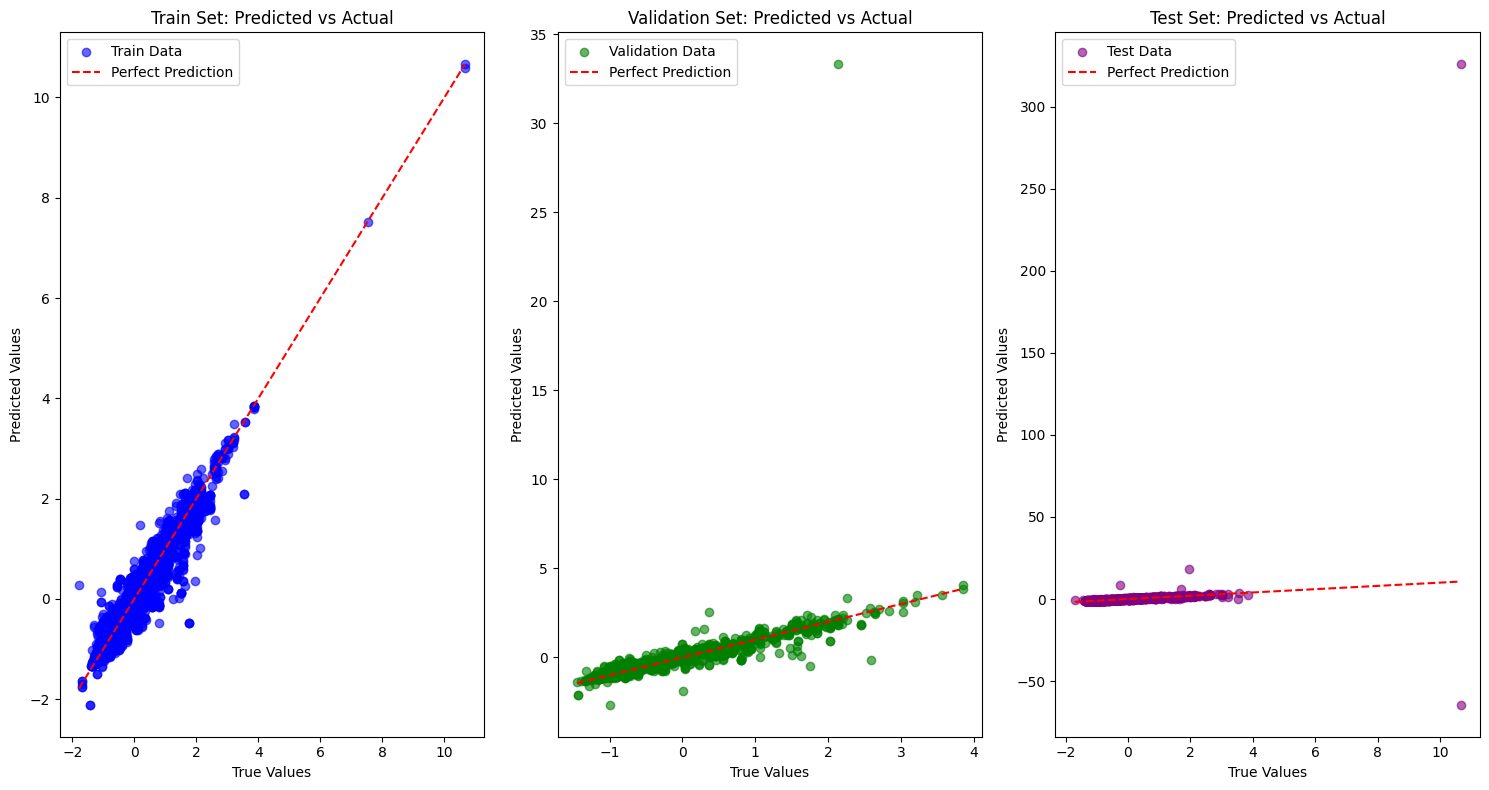

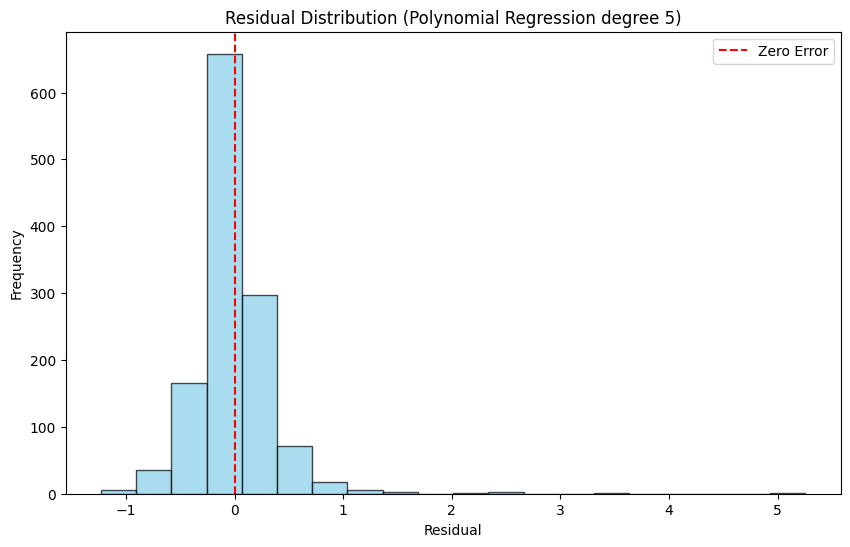

In [23]:
poly_best = PolynomialFeatures(degree=5)
X_train_poly_best = poly_best.fit_transform(X_train_selected_optional)
X_val_poly_best = poly_best.transform(X_val_selected_optional)
X_test_poly_best = poly_best.transform(X_test_selected_optional)

# Train the model
poly_model_best = LinearRegression()
poly_model_best.fit(X_train_poly_best, y_train_optional)

# Make predictions
y_train_pred = poly_model_best.predict(X_train_poly_best)
y_val_pred = poly_model_best.predict(X_val_poly_best)
y_test_pred = poly_model_best.predict(X_test_poly_best)

# Evaluate the model
mse_train = mean_squared_error(y_train_optional, y_train_pred)
mae_train = mean_absolute_error(y_train_optional, y_train_pred)
r2_train = r2_score(y_train_optional, y_train_pred)

mse_val = mean_squared_error(y_val_optional, y_val_pred)
mae_val = mean_absolute_error(y_val_optional, y_val_pred)
r2_val = r2_score(y_val_optional, y_val_pred)

mse_test = mean_squared_error(y_test_optional, y_test_pred)
mae_test = mean_absolute_error(y_test_optional, y_test_pred)
r2_test = r2_score(y_test_optional, y_test_pred)

# Print results
print(f"Training Set Evaluation (Best Polynomial Model):")
print(f"MSE: {mse_train}")
print(f"MAE: {mae_train}")
print(f"R²: {r2_train}\n")

print(f"Validation Set Evaluation (Best Polynomial Model):")
print(f"MSE: {mse_val}")
print(f"MAE: {mae_val}")
print(f"R²: {r2_val}\n")

print(f"Test Set Evaluation (Best Polynomial Model):")
print(f"MSE: {mse_test}")
print(f"MAE: {mae_test}")
print(f"R²: {r2_test}")

# Plot the predicted vs actual values for train, validation, and test sets
plt.figure(figsize=(15, 8))

# Plot for Train set
plt.subplot(1, 3, 1)
plt.scatter(y_train_optional, y_train_pred, color='blue', label='Train Data', alpha=0.6)
plt.plot([min(y_train_optional), max(y_train_optional)], [min(y_train_optional), max(y_train_optional)], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Train Set: Predicted vs Actual')
plt.legend()

# Plot for Validation set
plt.subplot(1, 3, 2)
plt.scatter(y_val_optional, y_val_pred, color='green', label='Validation Data', alpha=0.6)
plt.plot([min(y_val_optional), max(y_val_optional)], [min(y_val_optional), max(y_val_optional)], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Validation Set: Predicted vs Actual')
plt.legend()

# Plot for Test set
plt.subplot(1, 3, 3)
plt.scatter(y_test_optional, y_test_pred, color='purple', label='Test Data', alpha=0.6)
plt.plot([min(y_test_optional), max(y_test_optional)], [min(y_test_optional), max(y_test_optional)], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('Test Set: Predicted vs Actual')
plt.legend()

plt.tight_layout()
plt.show()

#  Error Distribution
y_test_pred = poly_model.predict(poly.transform(X_test_selected_optional))
residuals = y_test_optional - y_test_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Distribution (Polynomial Regression degree 5)')
plt.axvline(0, color='red', linestyle='--', label='Zero Error')
plt.legend()
plt.show()